<a href="https://colab.research.google.com/github/falahamro/Moral-Foundations-Analysis/blob/main/Holistic_Mapping_Moral_Foundations_of_Republicans_and_Democrats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import plotly.offline as py
import plotly.graph_objs as go

# Moral Foundations Analysis

In [9]:
# Load the data: speech transcripts from 2016 US Presidential campaigns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
campaign = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Moral Foundations Application/Mapping Morals of Republicans and Democrats/campaign_2016.csv", index_col=0)

In [11]:
campaign.head()

Candidate Party    Type               Date  \
0  Jeb Bush     R  speech      June 15, 2015   
1  Jeb Bush     R  speech      July 30, 2015   
2  Jeb Bush     R  speech    August 11, 2015   
3  Jeb Bush     R  speech  September 9, 2015   
4  Jeb Bush     R  speech   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  
0  Thank you all very much. I always feel welcome...  
1  Thank you all very much. I appreciate your hos...  
2  Thank you very much. It's good to be with all ...  
3  Thank you very much. I appreciate your hospita...  
4  Thank you. It's great to be in Tampa with so m...

In [12]:
# get basic summary statistics about the data

# We first look at the unique candidates

campaign['Candidate'].unique()

array(['Jeb Bush', 'Ben Carson', 'Lincoln Chafee', 'Chris Christie',
       'Hillary Clinton ', 'Ted Cruz', 'Carly Fiorina', 'Lindsey Graham',
       'Mike Huckabee', 'Bobby Jindal', 'John Kasich', "Martin O'Malley",
       'George Pataki', 'Rand Paul', 'Rick Perry', 'Marco Rubio',
       'Bernie Sanders', 'Rick Santorum', 'Donald Trump', 'Scott Walker',
       'Jim Webb'], dtype=object)

In [13]:
# Look at the duplicated texts

campaign['Text'].value_counts()[campaign['Text'].value_counts() > 1]

To view this video please enable JavaScript, and consider upgrading to a web browser thatsupports HTML5 video                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [14]:
# Find out if there are null values

campaign.isnull().sum()

Candidate      0
Party          0
Type           0
Date           0
Title          0
Text         124
dtype: int64

In [15]:
campaign[campaign.isnull().any(axis=1)]

Candidate Party           Type               Date  \
10         Jeb Bush     R  press release      June 15, 2015   
11         Jeb Bush     R  press release      June 15, 2015   
12         Jeb Bush     R  press release      June 16, 2015   
13         Jeb Bush     R  press release      June 16, 2015   
14         Jeb Bush     R  press release      June 16, 2015   
...             ...   ...            ...                ...   
6875  Rick Santorum     R  press release      March 7, 2012   
7161   Donald Trump     R  press release   November 9, 2015   
7230   Donald Trump     R  press release   January 31, 2016   
7248   Donald Trump     R  press release  February 20, 2016   
7395   Scott Walker     R  press release      July 15, 2015   

                                                  Title Text  
10               Press Release - I Know We Can Fix This  NaN  
11                    Press Release - I Will Run To Win  NaN  
12        Press Release - Best Part of Announcement Day  NaN  
13    Press Release - #JebNoFilter: New Hampshire Ed...  NaN  
14                            Press Release - Preparing  NaN  
...                                                 ...  ...  
6875   Press Release - An Interview with Karen Santorum  NaN  
7161       Press Release - Donald Trump Monologue - SNL  NaN  
7230  Press Release - Ivanka Trump - Find Your Iowa ...  NaN  
7248  Press Release - Donald J. Trump South Carolina...  NaN  
7395  Press Release - Announcing For President in 13...  NaN  

[124 rows x 6 columns]

In [16]:
# let's drop the null values with dropna

campaign.dropna(inplace=True)

In [17]:
campaign.describe()

Candidate Party           Type               Date  \
count               7361  7361           7361               7361   
unique                21     2              3               1193   
top     Hillary Clinton      R  press release  February 29, 2016   
freq                2504  4083           6090                 34   

                                          Title  \
count                                      7361   
unique                                     7196   
top     Press Release - Yesterday in the States   
freq                                         18   

                                                     Text  
count                                                7361  
unique                                               7328  
top     To view this video please enable JavaScript, a...  
freq                                                   10

OBSERVATIONS: 



1.   There are 7485 records but only 7361 texts, and only 7328 unique texts. We would expect that every record should have a unique text. This implies there are null or duplicate values.
2.   A few texts are duplicated (included as both press releases and statements), which could give an erroneous view of the content or frequency of a candidate's speech.


1.   There are 124 null-valued texts. From the titles, we can intuit that these are mostly videos. And, many of the duplicate texts also appear to be videos from their titles. This could affect text analysis: maybe politicians are more likely to talk to certain audiences or about certain topics using videos, which could skew our analysis.


As can be seen, there are a handful of null values in the 'Text' column. Null values can mess up calculations and need to be dealt with by filling them with a dummy value or deleting the row. Because the null values are for text, and because we're most interested in the text content, we'll drop the offending rows. How you deal with null values will vary on a project-by-project basis.





In [18]:
# Let's drop the null-valued rows with dropna
campaign.dropna(inplace=True)

**Feature extraction**

the number of characters per text

the number of words per text

the number of sentences per text

the average length of words per text

the average length of sentences per text

In [19]:
import nltk
import ssl

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
# we'll extract features from text data


campaign['clean_text'] = campaign['Text'].str.lower()
campaign['words'] = campaign['clean_text'].apply(nltk.word_tokenize)
campaign['sentences'] = campaign['clean_text'].apply(nltk.sent_tokenize)

In [22]:
campaign.head()

Candidate Party    Type               Date  \
0  Jeb Bush     R  speech      June 15, 2015   
1  Jeb Bush     R  speech      July 30, 2015   
2  Jeb Bush     R  speech    August 11, 2015   
3  Jeb Bush     R  speech  September 9, 2015   
4  Jeb Bush     R  speech   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   
3  Thank you very much. I appreciate your hospita...   
4  Thank you. It's great to be in Tampa with so m...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   
3  thank you very much. i appreciate your hospita...   
4  thank you. it's great to be in tampa with so m...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   
3  [thank, you, very, much, ., i, appreciate, you...   
4  [thank, you, ., it, 's, great, to, be, in, tam...   

                                           sentences  
0  [thank you all very much., i always feel welco...  
1  [thank you all very much., i appreciate your h...  
2  [thank you very much., it's good to be with al...  
3  [thank you very much., i appreciate your hospi...  
4  [thank you., it's great to be in tampa with so...

In [23]:
# We calculate the len on each column that has text
campaign['char_count'] = campaign['clean_text'].str.len()
campaign['word_count'] = campaign['words'].str.len()
campaign['sentence_count'] = campaign['sentences'].str.len()
campaign['avg_word_length'] = campaign['char_count'] / campaign['word_count']
campaign['avg_sentence_length'] = campaign['word_count'] / campaign['sentence_count']

In [24]:
campaign

Candidate Party       Type                Date  \
0         Jeb Bush     R     speech       June 15, 2015   
1         Jeb Bush     R     speech       July 30, 2015   
2         Jeb Bush     R     speech     August 11, 2015   
3         Jeb Bush     R     speech   September 9, 2015   
4         Jeb Bush     R     speech    November 2, 2015   
...            ...   ...        ...                 ...   
7480  Scott Walker     R  statement  September 11, 2015   
7481  Scott Walker     R  statement  September 11, 2015   
7482      Jim Webb     D     speech  September 24, 2015   
7483      Jim Webb     D  statement        July 2, 2015   
7484      Jim Webb     D  statement    October 20, 2015   

                                                  Title  \
0     Remarks Announcing Candidacy for President at ...   
1     Remarks to the National Urban League Conferenc...   
2     Remarks at the Ronald Reagan Presidential Libr...   
3                     Remarks in Garner, North Carolina   
4                             Remarks in Tampa, Florida   
...                                                 ...   
7480  Statement by Governor Walker on the 14th Anniv...   
7481  Statement by Governor Walker on the Three-Year...   
7482  Remarks in RFD-TVs "Rural Town Hall" West Des ...   
7483       Statement Announcing Candidacy for President   
7484  Statement Announcing the End of Campaign Activ...   

                                                   Text  \
0     Thank you all very much. I always feel welcome...   
1     Thank you all very much. I appreciate your hos...   
2     Thank you very much. It's good to be with all ...   
3     Thank you very much. I appreciate your hospita...   
4     Thank you. It's great to be in Tampa with so m...   
...                                                 ...   
7480  Milwaukee, Wis. -- Today, Gov. Scott Walker re...   
7481  Milwaukee, Wis. -- Gov. Scott Walker issued th...   
7482  OPPOLD:And from the beautiful Stine's Family B...   
7483  Dear friends:After many months of thought, del...   
7484  Several years ago Senator Daniel Patrick Moyni...   

                                             clean_text  \
0     thank you all very much. i always feel welcome...   
1     thank you all very much. i appreciate your hos...   
2     thank you very much. it's good to be with all ...   
3     thank you very much. i appreciate your hospita...   
4     thank you. it's great to be in tampa with so m...   
...                                                 ...   
7480  milwaukee, wis. -- today, gov. scott walker re...   
7481  milwaukee, wis. -- gov. scott walker issued th...   
7482  oppold:and from the beautiful stine's family b...   
7483  dear friends:after many months of thought, del...   
7484  several years ago senator daniel patrick moyni...   

                                                  words  \
0     [thank, you, all, very, much, ., i, always, fe...   
1     [thank, you, all, very, much, ., i, appreciate...   
2     [thank, you, very, much, ., it, 's, good, to, ...   
3     [thank, you, very, much, ., i, appreciate, you...   
4     [thank, you, ., it, 's, great, to, be, in, tam...   
...                                                 ...   
7480  [milwaukee, ,, wis., --, today, ,, gov, ., sco...   
7481  [milwaukee, ,, wis., --, gov, ., scott, walker...   
7482  [oppold, :, and, from, the, beautiful, stine, ...   
7483  [dear, friends, :, after, many, months, of, th...   
7484  [several, years, ago, senator, daniel, patrick...   

                                              sentences  char_count  \
0     [thank you all very much., i always feel welco...       12383   
1     [thank you all very much., i appreciate your h...       14457   
2     [thank you very much., it's good to be with al...       21283   
3     [thank you very much., i appreciate your hospi...       10049   
4     [thank you., it's great to be in tampa with so...       14189   
...                                   

In [25]:
# Let's convert the Date colun to type datetime

campaign['datetime'] = pd.to_datetime(campaign['Date'])

campaign.head()

Candidate Party    Type               Date  \
0  Jeb Bush     R  speech      June 15, 2015   
1  Jeb Bush     R  speech      July 30, 2015   
2  Jeb Bush     R  speech    August 11, 2015   
3  Jeb Bush     R  speech  September 9, 2015   
4  Jeb Bush     R  speech   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   
3  Thank you very much. I appreciate your hospita...   
4  Thank you. It's great to be in Tampa with so m...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   
3  thank you very much. i appreciate your hospita...   
4  thank you. it's great to be in tampa with so m...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   
3  [thank, you, very, much, ., i, appreciate, you...   
4  [thank, you, ., it, 's, great, to, be, in, tam...   

                                           sentences  char_count  word_count  \
0  [thank you all very much., i always feel welco...       12383        2338   
1  [thank you all very much., i appreciate your h...       14457        2868   
2  [thank you very much., it's good to be with al...       21283        4061   
3  [thank you very much., i appreciate your hospi...       10049        2030   
4  [thank you., it's great to be in tampa with so...       14189        2564   

   sentence_count  avg_word_length  avg_sentence_length   datetime  
0              47         5.296407            49.744681 2015-06-15  
1             126         5.040795            22.761905 2015-07-30  
2             132         5.240827            30.765152 2015-08-11  
3              92         4.950246            22.065217 2015-09-09  
4              37         5.533931            69.297297 2015-11-02

Text(0.5, 1.0, 'word count')

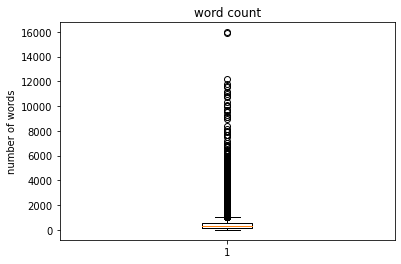

In [26]:
# let's make a boxplot of the word counts

plt.boxplot(campaign['word_count'])
plt.ylabel('number of words')
plt.title('word count')

We can see that over half of our texts contain less than a thousand words, but many texts contain several times that.

Let's a dataframe that only has type 'speech', and another dataframe that only has type 'statement'. Then, we make a box plot for each. we compare the box plots for word counts to those for word length, sentence length, or character count.

Text(0.5, 1.0, 'speech word count')

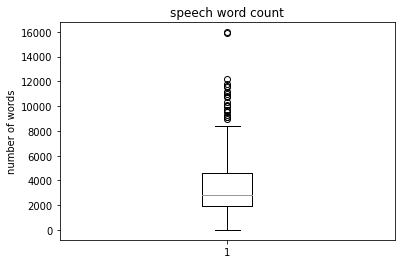

In [27]:
campaign = campaign[campaign['Type'] == 'speech']
plt.boxplot(campaign['word_count'])
plt.ylabel('number of words')
plt.title('speech word count')

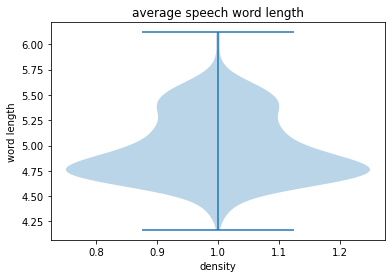

In [28]:
plt.violinplot(campaign['avg_word_length'])
plt.ylabel('word length')
plt.xlabel('density')
plt.title('average speech word length');

# Principal Components Analysis

In [29]:
from nltk.stem.snowball import SnowballStemmer
import os
import re
import json

Moral Foundations Dictionary 

A quanteda dictionary object containing the Moral Foundations Dictionary, a publicly available dictionaries with information on the proportions of virtue and vice words for each foundation. The categories are harm (vice/virtue), fairness (vice/virtue), ingroup (vice/virtue), authority (vice/virtue), purity (vice/virtue) and morality (general).



In [30]:
# Let's load the dictionary into the mft_dict variable

with open('/content/drive/MyDrive/Colab Notebooks/Moral Foundations Application/Mapping Morals of Republicans and Democrats/foundations_dict.json') as json_data:
    mft_dict = json.load(json_data)

# Stem the words in your dictionary (this will help you get more matches)
stemmer = SnowballStemmer('english')

for foundation in mft_dict.keys():
    curr_words = mft_dict[foundation]
    stemmed_words = [stemmer.stem(word) for word in curr_words]
    mft_dict[foundation] = stemmed_words

In [31]:
# Stem the words in your dictionary (this will help you get more matches)
stemmer = SnowballStemmer('english')

for foundation in mft_dict.keys():
    curr_words = mft_dict[foundation]
    stemmed_words = [stemmer.stem(word) for word in curr_words]
    mft_dict[foundation] = stemmed_words

In [32]:
# Let's view the dictionary keys using the .key() function:

keys = mft_dict.keys()
list(keys)

['authority/subversion',
 'care/harm',
 'fairness/cheating',
 'liberty/oppression',
 'loyalty/betrayal',
 'sanctity/degradation']

In [33]:
# Check the entries associated with a key in brackets

mft_dict

{'authority/subversion': ['respect',
  'esteem',
  'regard',
  'subver',
  'say-so',
  'offic',
  'disrespect',
  'valu',
  'obedi',
  'assur',
  'honor',
  'disesteem',
  'agenc',
  'corrupt',
  'honour',
  'domin',
  'author',
  'observ',
  'confid',
  'defer',
  'bureau',
  'authori',
  'sure',
  'sanction'],
 'care/harm': ['hurt',
  'scath',
  'precaut',
  'concern',
  'attent',
  'damag',
  'care',
  'manag',
  'impair',
  'worri',
  'harm',
  'trauma',
  'guardianship',
  'aid',
  'tend',
  'caution',
  'forethought',
  'tutelag',
  'injuri',
  'upkeep',
  'mainten',
  'charg'],
 'fairness/cheating': ['equiti',
  'fair',
  'cuckold',
  'unsportsmanlik',
  'screw',
  'dirti',
  'candour',
  'cheat',
  'proport',
  'balanc',
  'inequ',
  'chican',
  'betray',
  'candor',
  'adult',
  'chous',
  'unsport',
  'unfair',
  'two-tim',
  'foul',
  'shaft',
  'fair-mind'],
 'liberty/oppression': ['self-direct',
  'self-suffici',
  'autonomi',
  'conquest',
  'burdensom',
  'independ',
  '

Observations: 

Note the enries in the dictionary have been stemmed. In other words, they have been reduced to their smallest meaningful root. 

In [34]:
# Let's try and check the number of times a second string appears in the first string


"Data science is the best major, says data scientist.".count('science')

1

In [35]:
# Let's try the lower function: 

"Rhetoric major says back: NEVER argue with a rhetoric student.".lower()

'rhetoric major says back: never argue with a rhetoric student.'

In [36]:
def clean_text(text):
    # remove punctuation using a regular expression (not covered in these modules)
    p = re.compile(r'[^\w\s]')
    no_punc = p.sub(' ', text)
    # convert to lowercase
    no_punc_lower = no_punc.lower()
    # split into individual words
    clean = no_punc_lower.split()
    return clean
    
campaign['clean_speech'] = [clean_text(s) for s in campaign['Text']]

campaign.head()

Candidate Party    Type               Date  \
0  Jeb Bush     R  speech      June 15, 2015   
1  Jeb Bush     R  speech      July 30, 2015   
2  Jeb Bush     R  speech    August 11, 2015   
3  Jeb Bush     R  speech  September 9, 2015   
4  Jeb Bush     R  speech   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   
3  Thank you very much. I appreciate your hospita...   
4  Thank you. It's great to be in Tampa with so m...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   
3  thank you very much. i appreciate your hospita...   
4  thank you. it's great to be in tampa with so m...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   
3  [thank, you, very, much, ., i, appreciate, you...   
4  [thank, you, ., it, 's, great, to, be, in, tam...   

                                           sentences  char_count  word_count  \
0  [thank you all very much., i always feel welco...       12383        2338   
1  [thank you all very much., i appreciate your h...       14457        2868   
2  [thank you very much., it's good to be with al...       21283        4061   
3  [thank you very much., i appreciate your hospi...       10049        2030   
4  [thank you., it's great to be in tampa with so...       14189        2564   

   sentence_count  avg_word_length  avg_sentence_length   datetime  \
0              47         5.296407            49.744681 2015-06-15   
1             126         5.040795            22.761905 2015-07-30   
2             132         5.240827            30.765152 2015-08-11   
3              92         4.950246            22.065217 2015-09-09   
4              37         5.533931            69.297297 2015-11-02   

                                        clean_speech  
0  [thank, you, all, very, much, i, always, feel,...  
1  [thank, you, all, very, much, i, appreciate, y...  
2  [thank, you, very, much, it, s, good, to, be, ...  
3  [thank, you, very, much, i, appreciate, your, ...  
4  [thank, you, it, s, great, to, be, in, tampa, ...

In [37]:
# create a new column called 'total_words'
campaign['total_words'] = [len(speech) for speech in campaign['clean_speech']]
campaign.head()

Candidate Party    Type               Date  \
0  Jeb Bush     R  speech      June 15, 2015   
1  Jeb Bush     R  speech      July 30, 2015   
2  Jeb Bush     R  speech    August 11, 2015   
3  Jeb Bush     R  speech  September 9, 2015   
4  Jeb Bush     R  speech   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   
3  Thank you very much. I appreciate your hospita...   
4  Thank you. It's great to be in Tampa with so m...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   
3  thank you very much. i appreciate your hospita...   
4  thank you. it's great to be in tampa with so m...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   
3  [thank, you, very, much, ., i, appreciate, you...   
4  [thank, you, ., it, 's, great, to, be, in, tam...   

                                           sentences  char_count  word_count  \
0  [thank you all very much., i always feel welco...       12383        2338   
1  [thank you all very much., i appreciate your h...       14457        2868   
2  [thank you very much., it's good to be with al...       21283        4061   
3  [thank you very much., i appreciate your hospi...       10049        2030   
4  [thank you., it's great to be in tampa with so...       14189        2564   

   sentence_count  avg_word_length  avg_sentence_length   datetime  \
0              47         5.296407            49.744681 2015-06-15   
1             126         5.040795            22.761905 2015-07-30   
2             132         5.240827            30.765152 2015-08-11   
3              92         4.950246            22.065217 2015-09-09   
4              37         5.533931            69.297297 2015-11-02   

                                        clean_speech  total_words  
0  [thank, you, all, very, much, i, always, feel,...         2284  
1  [thank, you, all, very, much, i, appreciate, y...         2638  
2  [thank, you, very, much, it, s, good, to, be, ...         3735  
3  [thank, you, very, much, i, appreciate, your, ...         1880  
4  [thank, you, it, s, great, to, be, in, tampa, ...         2550

In [38]:
#Note: much of the following code is not covered in these modules. Read the comments to get a sense of what it does.

# do the following code for each foundation
for foundation in mft_dict.keys():
    # create a new, empty column
    num_match_words = np.zeros(len(campaign))
    stems = mft_dict[foundation]
    
    # do the following code for each foundation word
    for stem in stems:
        # find synonym matches
        wd_count = np.array([sum([wd.startswith(stem) for wd in speech]) for speech in campaign['clean_speech']])
        # add the number of matches to the total
        num_match_words += wd_count
        
    # create a new column for each foundation with the number of foundation words per speech
    campaign[foundation] = num_match_words

campaign.head()

Candidate Party    Type               Date  \
0  Jeb Bush     R  speech      June 15, 2015   
1  Jeb Bush     R  speech      July 30, 2015   
2  Jeb Bush     R  speech    August 11, 2015   
3  Jeb Bush     R  speech  September 9, 2015   
4  Jeb Bush     R  speech   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   
3  Thank you very much. I appreciate your hospita...   
4  Thank you. It's great to be in Tampa with so m...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   
3  thank you very much. i appreciate your hospita...   
4  thank you. it's great to be in tampa with so m...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   
3  [thank, you, very, much, ., i, appreciate, you...   
4  [thank, you, ., it, 's, great, to, be, in, tam...   

                                           sentences  char_count  ...  \
0  [thank you all very much., i always feel welco...       12383  ...   
1  [thank you all very much., i appreciate your h...       14457  ...   
2  [thank you very much., it's good to be with al...       21283  ...   
3  [thank you very much., i appreciate your hospi...       10049  ...   
4  [thank you., it's great to be in tampa with so...       14189  ...   

   avg_sentence_length   datetime  \
0            49.744681 2015-06-15   
1            22.761905 2015-07-30   
2            30.765152 2015-08-11   
3            22.065217 2015-09-09   
4            69.297297 2015-11-02   

                                        clean_speech  total_words  \
0  [thank, you, all, very, much, i, always, feel,...         2284   
1  [thank, you, all, very, much, i, appreciate, y...         2638   
2  [thank, you, very, much, it, s, good, to, be, ...         3735   
3  [thank, you, very, much, i, appreciate, your, ...         1880   
4  [thank, you, it, s, great, to, be, in, tampa, ...         2550   

  authority/subversion care/harm  fairness/cheating  liberty/oppression  \
0                  4.0       4.0                3.0                 0.0   
1                  8.0       2.0                7.0                 0.0   
2                 12.0       5.0                1.0                 0.0   
3                  3.0       1.0                1.0                 0.0   
4                  8.0       3.0                1.0                 1.0   

   loyalty/betrayal  sanctity/degradation  
0               7.0                   4.0  
1               4.0                   9.0  
2               4.0                   5.0  
3               1.0                   4.0  
4               0.0                   7.0  

[5 rows x 23 columns]

In [39]:
# We divide the number of matched words by the number of total words and multiply by 100

for foundation in mft_dict.keys():
    campaign[foundation] = (campaign[foundation] / campaign['total_words']) * 100

campaign.head()

Candidate Party    Type               Date  \
0  Jeb Bush     R  speech      June 15, 2015   
1  Jeb Bush     R  speech      July 30, 2015   
2  Jeb Bush     R  speech    August 11, 2015   
3  Jeb Bush     R  speech  September 9, 2015   
4  Jeb Bush     R  speech   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   
3  Thank you very much. I appreciate your hospita...   
4  Thank you. It's great to be in Tampa with so m...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   
3  thank you very much. i appreciate your hospita...   
4  thank you. it's great to be in tampa with so m...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   
3  [thank, you, very, much, ., i, appreciate, you...   
4  [thank, you, ., it, 's, great, to, be, in, tam...   

                                           sentences  char_count  ...  \
0  [thank you all very much., i always feel welco...       12383  ...   
1  [thank you all very much., i appreciate your h...       14457  ...   
2  [thank you very much., it's good to be with al...       21283  ...   
3  [thank you very much., i appreciate your hospi...       10049  ...   
4  [thank you., it's great to be in tampa with so...       14189  ...   

   avg_sentence_length   datetime  \
0            49.744681 2015-06-15   
1            22.761905 2015-07-30   
2            30.765152 2015-08-11   
3            22.065217 2015-09-09   
4            69.297297 2015-11-02   

                                        clean_speech  total_words  \
0  [thank, you, all, very, much, i, always, feel,...         2284   
1  [thank, you, all, very, much, i, appreciate, y...         2638   
2  [thank, you, very, much, it, s, good, to, be, ...         3735   
3  [thank, you, very, much, i, appreciate, your, ...         1880   
4  [thank, you, it, s, great, to, be, in, tampa, ...         2550   

  authority/subversion care/harm  fairness/cheating  liberty/oppression  \
0             0.175131  0.175131           0.131349            0.000000   
1             0.303260  0.075815           0.265353            0.000000   
2             0.321285  0.133869           0.026774            0.000000   
3             0.159574  0.053191           0.053191            0.000000   
4             0.313725  0.117647           0.039216            0.039216   

   loyalty/betrayal  sanctity/degradation  
0          0.306480              0.175131  
1          0.151630              0.341168  
2          0.107095              0.133869  
3          0.053191              0.212766  
4          0.000000              0.274510  

[5 rows x 23 columns]

Associations and distributions

In [40]:
campaign.corr()

char_count  word_count  sentence_count  avg_word_length  \
char_count              1.000000    0.994885        0.854876        -0.134035   
word_count              0.994885    1.000000        0.890817        -0.215433   
sentence_count          0.854876    0.890817        1.000000        -0.421230   
avg_word_length        -0.134035   -0.215433       -0.421230         1.000000   
avg_sentence_length     0.022705    0.001708       -0.226714         0.303163   
total_words             0.998011    0.998354        0.868809        -0.176677   
authority/subversion   -0.103234   -0.124390       -0.160082         0.327019   
care/harm               0.018087    0.015341        0.011832        -0.050382   
fairness/cheating       0.050130    0.041282        0.026358         0.088012   
liberty/oppression     -0.043585   -0.056405       -0.082233         0.137036   
loyalty/betrayal        0.005400    0.000826       -0.007352        -0.020112   
sanctity/degradation   -0.129760   -0.128083       -0.089451         0.018495   

                      avg_sentence_length  total_words  authority/subversion  \
char_count                       0.022705     0.998011             -0.103234   
word_count                       0.001708     0.998354             -0.124390   
sentence_count                  -0.226714     0.868809             -0.160082   
avg_word_length                  0.303163    -0.176677              0.327019   
avg_sentence_length              1.000000     0.021961              0.157316   
total_words                      0.021961     1.000000             -0.113361   
authority/subversion             0.157316    -0.113361              1.000000   
care/harm                       -0.051445     0.015736             -0.064078   
fairness/cheating               -0.027176     0.044444              0.058542   
liberty/oppression               0.003046    -0.052027              0.029115   
loyalty/betrayal                -0.068631     0.001517              0.035874   
sanctity/degradation            -0.030443    -0.129440              0.221567   

                      care/harm  fairness/cheating  liberty/oppression  \
char_count             0.018087           0.050130           -0.043585   
word_count             0.015341           0.041282           -0.056405   
sentence_count         0.011832           0.026358           -0.082233   
avg_word_length       -0.050382           0.088012            0.137036   
avg_sentence_length   -0.051445          -0.027176            0.003046   
total_words            0.015736           0.044444           -0.052027   
authority/subversion  -0.064078           0.058542            0.029115   
care/harm              1.000000          -0.001272            0.007080   
fairness/cheating     -0.001272           1.000000           -0.033713   
liberty/oppression     0.007080          -0.033713            1.000000   
loyalty/betrayal       0.003034          -0.037136            0.097022   
sanctity/degradation  -0.018015          -0.019747            0.015651   

                      loyalty/betrayal  sanctity/degradation  
char_count                    0.005400             -0.129760  
word_count                    0.000826             -0.128083  
sentence_count               -0.007352             -0.089451  
avg_word_length              -0.020112              0.018495  
avg_sentence_length          -0.068631             -0.030443  
total_words                   0.001517             -0.129440  
authority/subversion          0.035874              0.221567  
care/harm                     0.003034             -0.018015  
fairness/cheating            -0.037136             -0.019747  
liberty/oppression            0.097022              0.015651  
loyalty/betrayal              1.000000              0.105360  
sanctity/degradation          0.105360              1.000000

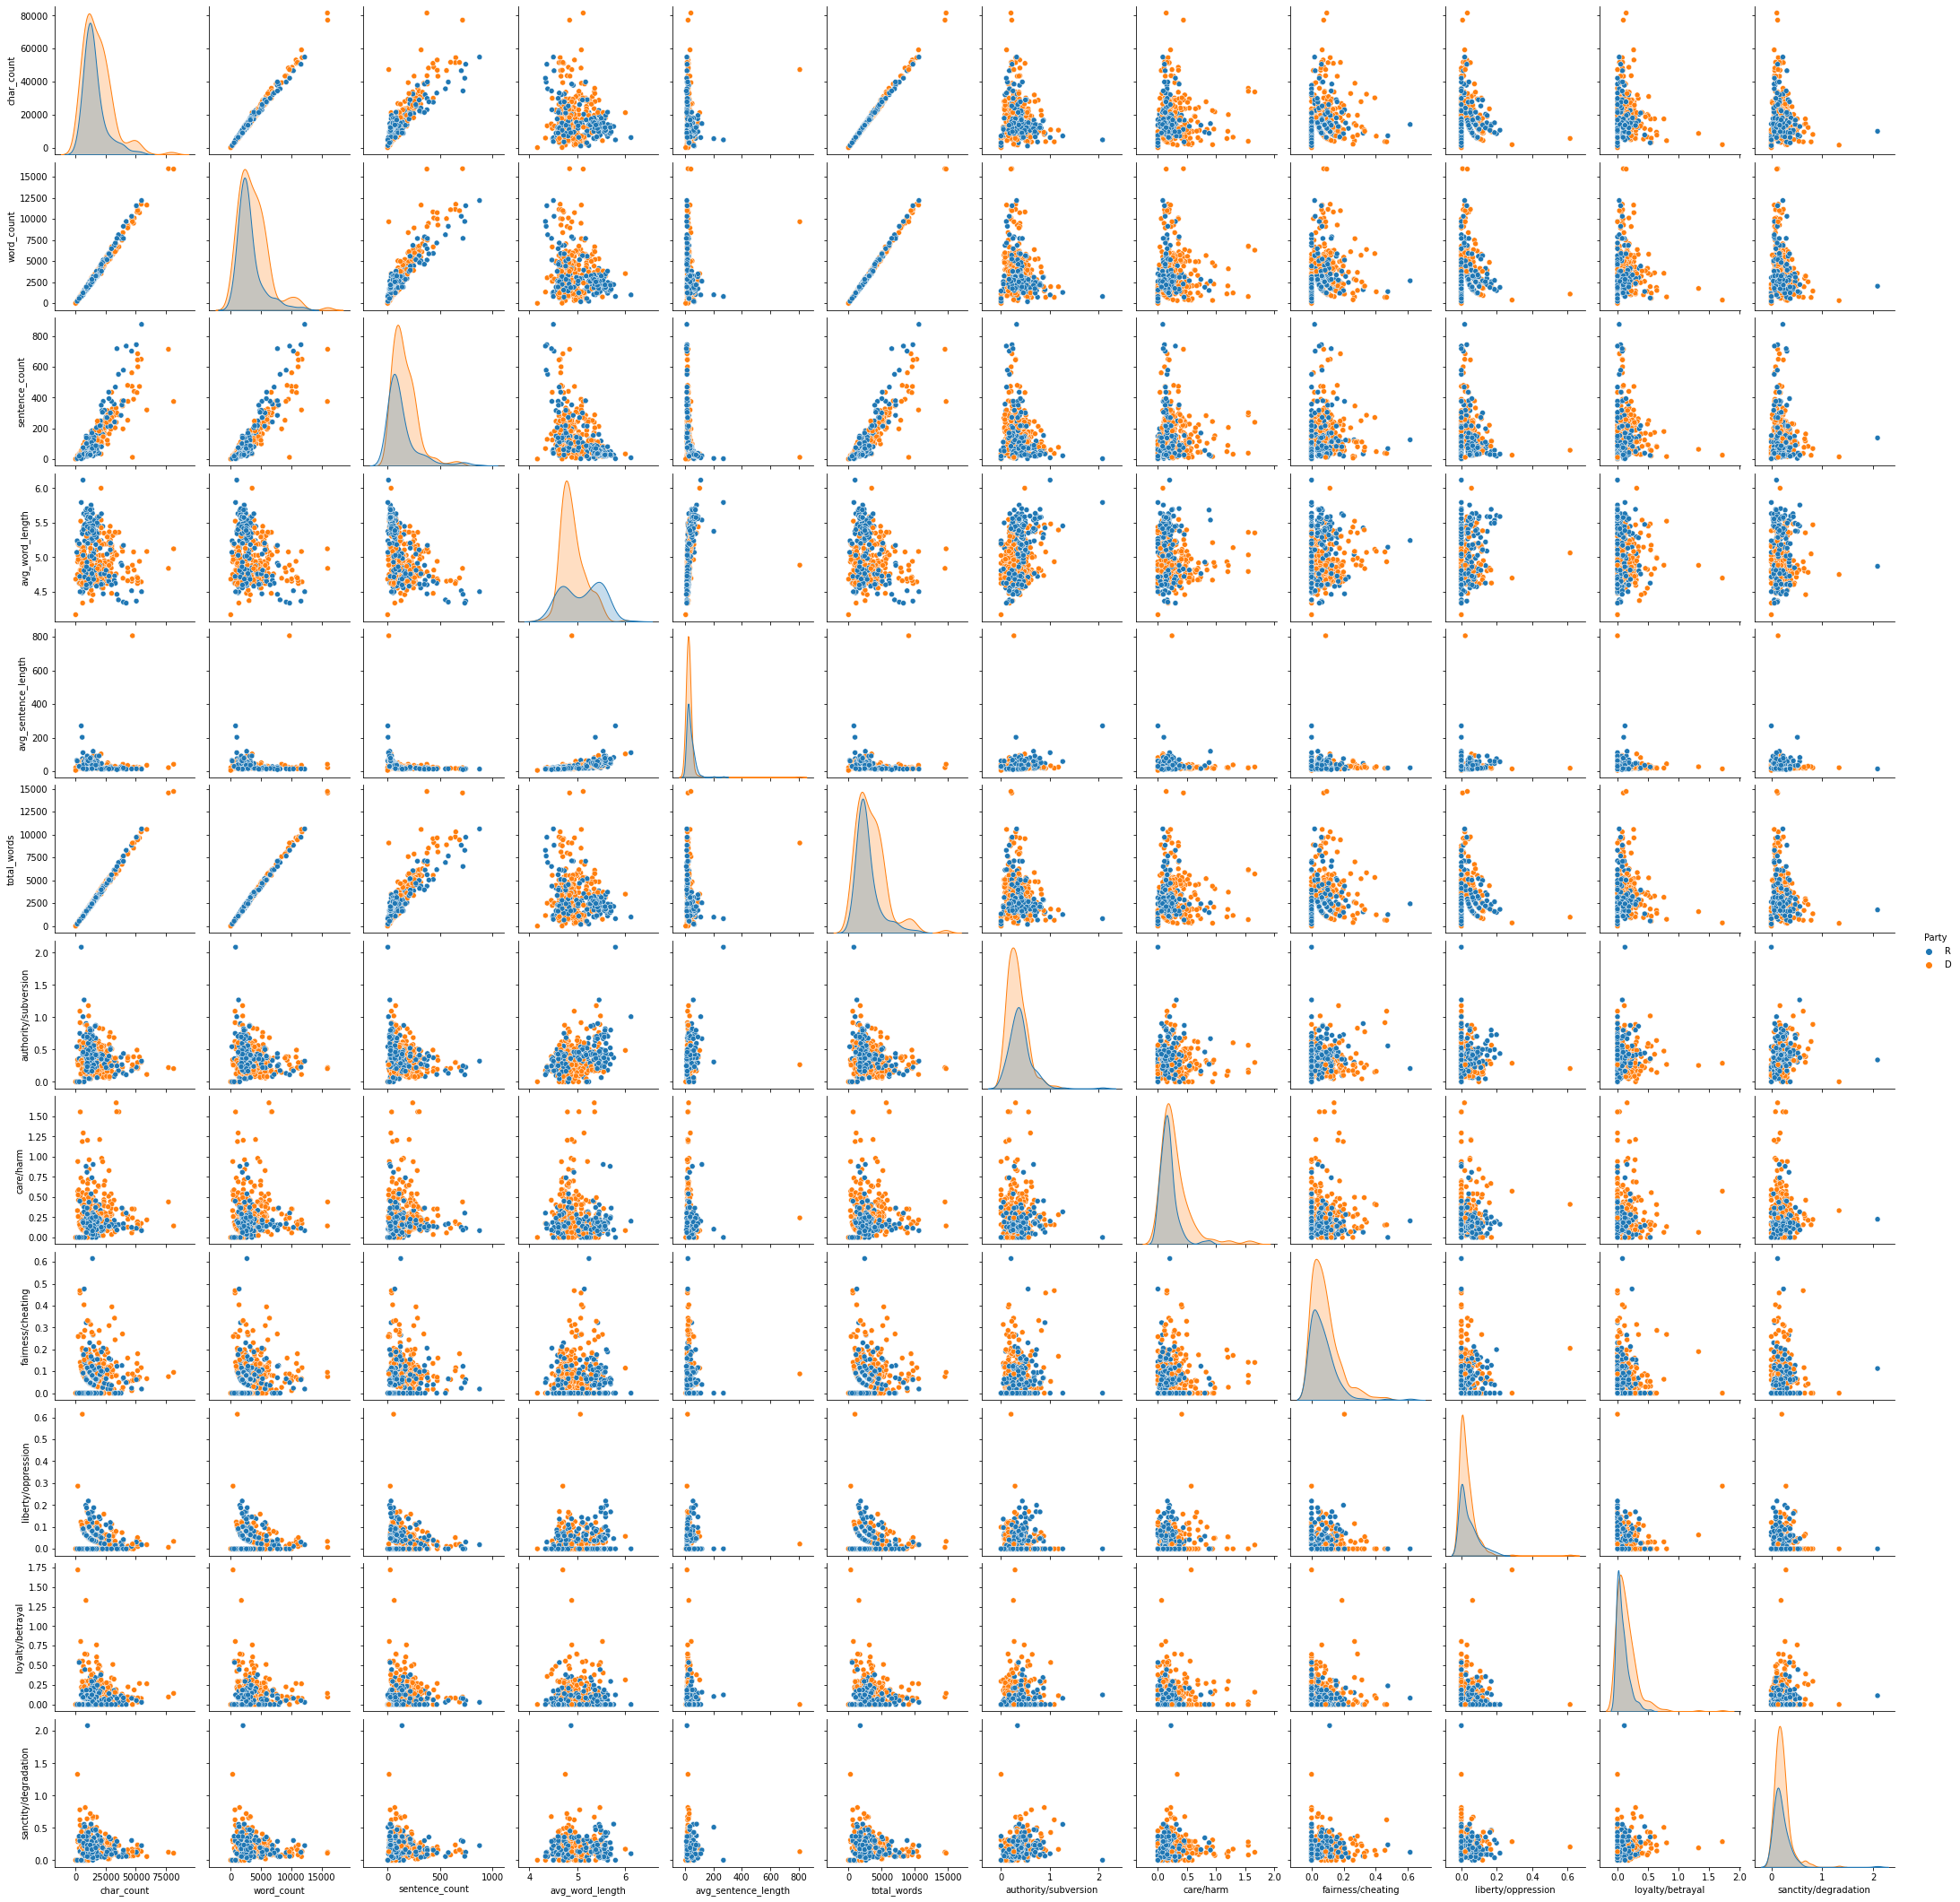

In [41]:
plt.rcParams.update({'figure.max_open_warning': 0})
sns.pairplot(campaign, hue="Party")

In-group out-group differences

In [42]:
def get_moral_party(campaign, moral, party):
    return campaign[campaign['Party'] == party][moral].groupby(campaign[campaign['Party'] == party].Candidate).mean()

def get_moral_party_df(campaign):

    rep_purity = get_moral_party(campaign, "authority/subversion", "R")
    dem_purity = get_moral_party(campaign, "authority/subversion", "D")

    rep_fairness = get_moral_party(campaign, "care/harm", "R")
    dem_fairness = get_moral_party(campaign, "care/harm", "D")

    rep_ingroup = get_moral_party(campaign, "fairness/cheating", "R")
    dem_ingroup = get_moral_party(campaign, "fairness/cheating", "D")

    rep_harm = get_moral_party(campaign, "liberty/oppression", "R")
    dem_harm = get_moral_party(campaign, "liberty/oppression", "D")

    repauth = get_moral_party(campaign, "loyalty/betrayal", "R")
    dem_auth = get_moral_party(campaign, "loyalty/betrayal", "D")

    rep_auth = get_moral_party(campaign, "sanctity/degradation", "R")
    dem_auth = get_moral_party(campaign, "sanctity/degradation", "D")
    
    return pd.DataFrame({
        "rep_purity": rep_purity, "dem_purity": dem_purity,
        "rep_fairness": rep_fairness, "dem_fairness": dem_fairness,
        "rep_harm": rep_harm, "dem_harm": dem_harm,
        "rep_ingroup": rep_ingroup, "dem_ingroup": dem_ingroup,
        "rep_auth": rep_auth, "dem_auth": dem_auth
        })

In [43]:
moral_heat = get_moral_party_df(campaign)
moral_heat

rep_purity  dem_purity  rep_fairness  dem_fairness  \
Candidate                                                              
Ben Carson          0.102743         NaN      0.229565           NaN   
Bernie Sanders           NaN    0.249612           NaN      0.225785   
Bobby Jindal        0.349786         NaN      0.155461           NaN   
Carly Fiorina       0.543478         NaN      0.000000           NaN   
Chris Christie      0.352694         NaN      0.138866           NaN   
Donald Trump        0.440846         NaN      0.188773           NaN   
George Pataki       0.504141         NaN      0.180050           NaN   
Hillary Clinton          NaN    0.349255           NaN      0.326387   
Jeb Bush            0.263235         NaN      0.109633           NaN   
Jim Webb                 NaN    0.264026           NaN      0.242024   
John Kasich         0.866898         NaN      0.278670           NaN   
Lincoln Chafee           NaN    0.239099           NaN      0.176214   
Lindsey Graham      0.459237         NaN      0.068836           NaN   
Marco Rubio         0.306846         NaN      0.074372           NaN   
Martin O'Malley          NaN    0.246645           NaN      0.086871   
Mike Huckabee       0.326643         NaN      0.142974           NaN   
Rand Paul           0.185468         NaN      0.214488           NaN   
Rick Perry          0.424913         NaN      0.125500           NaN   
Rick Santorum       0.319741         NaN      0.272907           NaN   
Scott Walker        0.291350         NaN      0.146359           NaN   
Ted Cruz            0.345712         NaN      0.125576           NaN   

                  rep_harm  dem_harm  rep_ingroup  dem_ingroup  rep_auth  \
Candidate                                                                  
Ben Carson        0.078664       NaN     0.000000          NaN  0.078664   
Bernie Sanders         NaN  0.039117          NaN     0.124735       NaN   
Bobby Jindal      0.000000       NaN     0.000000          NaN  0.116595   
Carly Fiorina     0.000000       NaN     0.000000          NaN  0.000000   
Chris Christie    0.000000       NaN     0.082560          NaN  1.094174   
Donald Trump      0.042448       NaN     0.060778          NaN  0.193221   
George Pataki     0.144040       NaN     0.072020          NaN  0.180050   
Hillary Clinton        NaN  0.027196          NaN     0.070440       NaN   
Jeb Bush          0.006536       NaN     0.085980          NaN  0.274695   
Jim Webb               NaN  0.022002          NaN     0.088009       NaN   
John Kasich       0.017464       NaN     0.069352          NaN  0.191349   
Lincoln Chafee         NaN  0.047594          NaN     0.119723       NaN   
Lindsey Graham    0.095441       NaN     0.072170          NaN  0.134320   
Marco Rubio       0.030973       NaN     0.053096          NaN  0.056449   
Martin O'Malley        NaN  0.031471          NaN     0.055674       NaN   
Mike Huckabee     0.013652       NaN     0.061744          NaN  0.138091   
Rand Paul         0.026240       NaN     0.054269          NaN  0.171948   
Rick Perry        0.041307       NaN     0.159444          NaN  0.179082   
Rick Santorum     0.038344       NaN     0.042387          NaN  0.160341   
Scott Walker      0.051880       NaN     0.051880          NaN  0.309451   
Ted Cruz          0.070622       NaN     0.016171          NaN  0.215709   

                  dem_auth  
Candidate                   
Ben Carson             NaN  
Bernie Sanders    0.150790  
Bobby Jindal           NaN  
Carly Fiorina          NaN  
Chris Christie         NaN  
Donald Trump           NaN  
George Pataki          NaN  
Hillary Clinton   0.222756  
Jeb Bush               NaN  
Jim Webb          0.132013  
John Kasich            NaN  
Lincoln Chafee    0.161269  
Lindsey Graham         NaN  
Marco Rubio            NaN  
Martin O'Malley   0.190890  
Mike Huckabee          NaN  
Rand Paul              NaN  
Rick Perry             NaN  
Rick Santorum          NaN  
Sco

Group by candidate

In [44]:
pc_df = campaign.groupby(campaign.Candidate).mean()
pc_df['Candidate'] = pc_df.index
pc_df

char_count   word_count  sentence_count  avg_word_length  \
Candidate                                                                      
Ben Carson        13446.000000  2923.000000      184.000000         4.681270   
Bernie Sanders    16471.800000  3337.700000      134.000000         4.930715   
Bobby Jindal      13976.000000  2951.000000      185.000000         4.736022   
Carly Fiorina      1004.000000   198.000000        3.000000         5.070707   
Chris Christie    14689.500000  3073.000000      161.500000         4.802433   
Donald Trump      18000.000000  3600.040541      165.148649         5.246845   
George Pataki     15070.000000  2961.000000       97.000000         5.089497   
Hillary Clinton   18899.678571  3881.015306      175.413265         4.866664   
Jeb Bush          12969.500000  2479.333333       73.166667         5.239596   
Jim Webb          47284.000000  9679.000000       12.000000         4.885215   
John Kasich       16447.000000  3099.500000      112.000000         5.306098   
Lincoln Chafee    13301.000000  2626.333333      126.666667         5.221132   
Lindsey Graham    15540.000000  2963.333333      131.333333         5.208049   
Marco Rubio       18108.750000  3683.250000      146.250000         4.935638   
Martin O'Malley   15695.818182  2962.636364       67.454545         5.285032   
Mike Huckabee     12435.687500  2670.000000      115.312500         4.625547   
Rand Paul         23700.000000  4892.500000      228.000000         4.965592   
Rick Perry        12022.000000  2257.937500       75.187500         5.286718   
Rick Santorum     12706.650000  2634.300000      112.950000         4.838773   
Scott Walker       8667.666667  1684.000000       60.333333         5.136412   
Ted Cruz          13511.666667  2724.000000      108.666667         4.985214   

                  avg_sentence_length  total_words  authority/subversion  \
Candidate                                                                  
Ben Carson                  17.644596  2534.500000              0.102743   
Bernie Sanders              27.028011  2985.316667              0.249612   
Bobby Jindal                15.951351  2573.000000              0.349786   
Carly Fiorina               66.000000   184.000000              0.543478   
Chris Christie              18.484920  2792.500000              0.352694   
Donald Trump                47.518099  3272.472973              0.440846   
George Pataki               30.525773  2777.000000              0.504141   
Hillary Clinton             22.984024  3501.494898              0.349255   
Jeb Bush                    66.272375  2344.333333              0.263235   
Jim Webb                   806.583333  9090.000000              0.264026   
John Kasich                 32.083766  2884.000000              0.866898   
Lincoln Chafee              30.563725  2398.666667              0.239099   
Lindsey Graham              22.931743  2727.333333              0.459237   
Marco Rubio                 26.944693  3380.750000              0.306846   
Martin O'Malley             54.006599  2818.818182              0.246645   
Mike Huckabee               23.072594  2351.250000              0.326643   
Rand Paul                   24.448894  4449.500000              0.185468   
Rick Perry                  34.086749  2117.750000              0.424913   
Rick Santorum               27.050603  2362.000000              0.319741   
Scott Walker                27.906981  1587.000000              0.291350   
Ted Cruz                    30.356509  2426.166667              0.345712   

                  care/harm  fairness/cheating  liberty/oppression  \
Candidate                                                            
Ben Carson         0.229565           0.000000            0.078664   
Bernie Sanders     0.225785           0.124735            0.039117   
Bobby Jindal       0.155461           0.000000            0.000000   
Carly Fiorina      0.000000           0.000000            0.000000   
Chris Chri

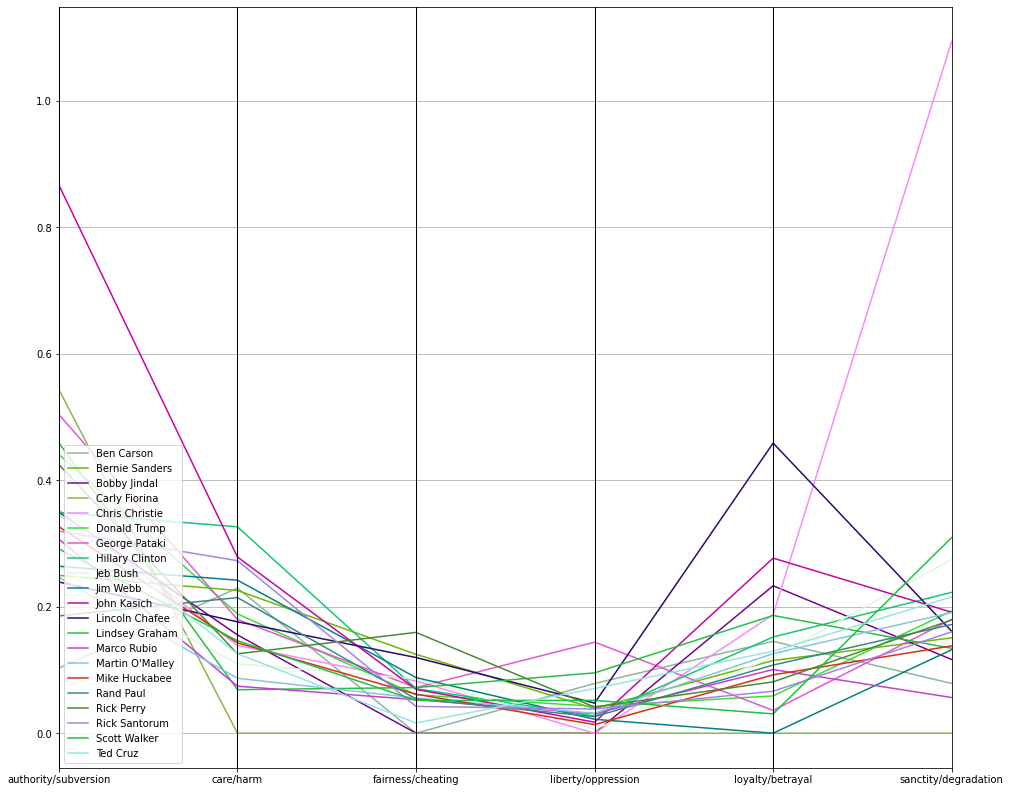

In [45]:
f, ax = plt.subplots(figsize=(16, 14))
pd.plotting.parallel_coordinates(pc_df, 'Candidate', 
                                 cols=["authority/subversion", "care/harm", "fairness/cheating", "liberty/oppression","loyalty/betrayal", "sanctity/degradation"])
ax.legend(loc="lower left");

Data Filtering by party

We use Boolean indexing to filter out rows of the table that correspond to speeches from other party. 

This can be done through these steps: 

1. identify the correct column 
2. specificy the desired condition for that column 
3. index the Dataframe with that condition in square brackets 

In [46]:
# Let's take a look on how to create a new table with only Bernie Sanders' speeches

speech_col = campaign['Candidate']

# specify the condition 

sanders_condition = speech_col == 'Bernie Sanders'

# index the original DataFrame by the condition 

sanders_speeches = campaign[sanders_condition]
sanders_speeches.head()

Candidate Party    Type            Date  \
5877  Bernie Sanders     D  speech  April 30, 2015   
5878  Bernie Sanders     D  speech  April 30, 2015   
5879  Bernie Sanders     D  speech  April 30, 2015   
5880  Bernie Sanders     D  speech     May 6, 2015   
5881  Bernie Sanders     D  speech    May 11, 2015   

                                                  Title  \
5877  Interview with Ed Schultz of MSNBC Regarding S...   
5878  Interview with Wolf Blitzer of CNN Regarding S...   
5879  Interview with Andrea Mitchell of MSNBC Regard...   
5880      Interview with Chris Cuomo of CNN's "New Day"   
5881            Interview with Andrea Mitchell of MSNBC   

                                                   Text  \
5877  Schultz: A gentleman who has appeared on the p...   
5878  Blitzer: I want to move to politics right now ...   
5879  Sanders (from video clip): I believe that in a...   
5880  CUOMO: Senator Sanders, welcome to the race. G...   
5881  MITCHELL: Vermont Senator and Democratic presi...   

                                             clean_text  \
5877  schultz: a gentleman who has appeared on the p...   
5878  blitzer: i want to move to politics right now ...   
5879  sanders (from video clip): i believe that in a...   
5880  cuomo: senator sanders, welcome to the race. g...   
5881  mitchell: vermont senator and democratic presi...   

                                                  words  \
5877  [schultz, :, a, gentleman, who, has, appeared,...   
5878  [blitzer, :, i, want, to, move, to, politics, ...   
5879  [sanders, (, from, video, clip, ), :, i, belie...   
5880  [cuomo, :, senator, sanders, ,, welcome, to, t...   
5881  [mitchell, :, vermont, senator, and, democrati...   

                                              sentences  char_count  ...  \
5877  [schultz: a gentleman who has appeared on the ...       19597  ...   
5878  [blitzer: i want to move to politics right now...        9538  ...   
5879  [sanders (from video clip): i believe that in ...        5584  ...   
5880  [cuomo: senator sanders, welcome to the race.,...        8412  ...   
5881  [mitchell: vermont senator and democratic pres...        5156  ...   

      avg_sentence_length   datetime  \
5877            19.018692 2015-04-30   
5878            17.623932 2015-04-30   
5879            19.017241 2015-04-30   
5880            18.708333 2015-05-06   
5881            17.864407 2015-05-11   

                                           clean_speech  total_words  \
5877  [schultz, a, gentleman, who, has, appeared, on...         3645   
5878  [blitzer, i, want, to, move, to, politics, rig...         1764   
5879  [sanders, from, video, clip, i, believe, that,...          976   
5880  [cuomo, senator, sanders, welcome, to, the, ra...         1561   
5881  [mitchell, vermont, senator, and, democratic, ...          910   

     authority/subversion care/harm  fairness/cheating  liberty/oppression  \
5877             0.329218  0.082305           0.054870            0.027435   
5878             0.566893  0.000000           0.056689            0.170068   
5879             0.204918  0.409836           0.204918            0.614754   
5880             0.128123  0.000000           0.192184            0.000000   
5881             0.219780  0.000000           0.000000            0.109890   

      loyalty/betrayal  sanctity/degradation  
5877          0.109739              0.109739  
5878          0.000000              0.453515  
5879          0.000000              0.204918  
5880          0.064061              0.064061  
5881          0.000000              0.219780  

[5 rows x 23 columns]

**Analysis on the Democrats**

In [47]:
# let's create a table that only contains Democrats using boolean indexing

# We start by filtering out non-Democrat speeaches

party_col = campaign['Party']

dem_cond = party_col =='D'

democrats = campaign[dem_cond]

democrats.head()

Candidate Party    Type              Date  \
436    Lincoln Chafee     D  speech      June 3, 2015   
437    Lincoln Chafee     D  speech     July 17, 2015   
438    Lincoln Chafee     D  speech  October 23, 2015   
570  Hillary Clinton      D  speech  January 20, 2007   
571  Hillary Clinton      D  speech  January 22, 2007   

                                                 Title  \
436  Remarks Announcing Candidacy for President at ...   
437  Remarks at the Iowa Democrats Hall of Fame Din...   
438  Remarks Announcing the End of Presidential Cam...   
570  Video Transcript: Presidential Exploratory Com...   
571  Remarks in a "Let the Conversation Begin Webcast"   

                                                  Text  \
436  Thank you, Bob. Thank you, Bob and Mark, very ...   
437  Congratulations to the Hall of Fame Inductees....   
438  Once again it is a pleasure to join so many De...   
570  HILLARY CLINTON: I announced today that I am f...   
571  SENATOR CLINTON: Hi, everyone, and welcome to ...   

                                            clean_text  \
436  thank you, bob. thank you, bob and mark, very ...   
437  congratulations to the hall of fame inductees....   
438  once again it is a pleasure to join so many de...   
570  hillary clinton: i announced today that i am f...   
571  senator clinton: hi, everyone, and welcome to ...   

                                                 words  \
436  [thank, you, ,, bob, ., thank, you, ,, bob, an...   
437  [congratulations, to, the, hall, of, fame, ind...   
438  [once, again, it, is, a, pleasure, to, join, s...   
570  [hillary, clinton, :, i, announced, today, tha...   
571  [senator, clinton, :, hi, ,, everyone, ,, and,...   

                                             sentences  char_count  ...  \
436  [thank you, bob., thank you, bob and mark, ver...       30480  ...   
437  [congratulations to the hall of fame inductees...        4220  ...   
438  [once again it is a pleasure to join so many d...        5203  ...   
570  [hillary clinton: i announced today that i am ...        1832  ...   
571  [senator clinton: hi, everyone, and welcome to...       27981  ...   

     avg_sentence_length   datetime  \
436            18.666667 2015-06-03   
437            44.941176 2015-07-17   
438            28.083333 2015-10-23   
570            15.000000 2007-01-20   
571            21.889299 2007-01-22   

                                          clean_speech  total_words  \
436  [thank, you, bob, thank, you, bob, and, mark, ...         5512   
437  [congratulations, to, the, hall, of, fame, ind...          745   
438  [once, again, it, is, a, pleasure, to, join, s...          939   
570  [hillary, clinton, i, announced, today, that, ...          349   
571  [senator, clinton, hi, everyone, and, welcome,...         5349   

    authority/subversion care/harm  fairness/cheating  liberty/oppression  \
436             0.235849  0.181422           0.090711            0.036284   
437             0.268456  0.134228           0.268456            0.000000   
438             0.212993  0.212993           0.000000            0.106496   
570             0.286533  0.573066           0.000000            0.286533   
571             0.355207  0.261731           0.037390            0.018695   

     loyalty/betrayal  sanctity/degradation  
436          0.145138              0.108853  
437          0.805369              0.268456  
438          0.425985              0.106496  
570          1.719198              0.286533  
571          0.149561              0.093475  

[5 rows x 23 columns]

Now that we have our percentages for the Democractic party, we can view the average percents for Democracts as a group. 

In [48]:
from pandas.core import apply
# we select the foundations columns and calculate the mean percent for each 

avg_dem_stats = (democrats.loc[:, list(mft_dict.keys())]
                 .apply(np.mean)
                 .to_frame('D_percent'))

avg_dem_stats

D_percent
authority/subversion   0.321495
care/harm              0.292418
fairness/cheating      0.082472
liberty/oppression     0.030215
loyalty/betrayal       0.145686
sanctity/degradation   0.204513

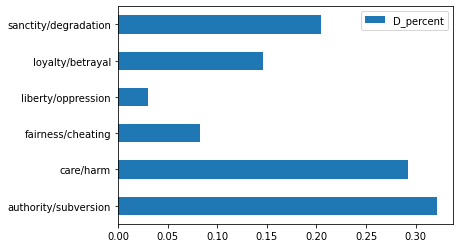

In [49]:
# let's create a horixontal bar plot using the .plot.barh() method on avg_dem_stats

avg_dem_stats.plot.barh()

**Republicans Analysis**

In [50]:
# we repeat the same analysis before to get the percent avg for the republican part

# Select the republican party column from the dataframe
party_col = campaign['Party']

# create a boolean expression/condition that checks if the a party is Republican
republican_cond = party_col == 'R'

# index the dataframe using 'republican_cond'
republicans = campaign[republican_cond]

republicans.head()

Candidate Party    Type               Date  \
0  Jeb Bush     R  speech      June 15, 2015   
1  Jeb Bush     R  speech      July 30, 2015   
2  Jeb Bush     R  speech    August 11, 2015   
3  Jeb Bush     R  speech  September 9, 2015   
4  Jeb Bush     R  speech   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   
3  Thank you very much. I appreciate your hospita...   
4  Thank you. It's great to be in Tampa with so m...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   
3  thank you very much. i appreciate your hospita...   
4  thank you. it's great to be in tampa with so m...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   
3  [thank, you, very, much, ., i, appreciate, you...   
4  [thank, you, ., it, 's, great, to, be, in, tam...   

                                           sentences  char_count  ...  \
0  [thank you all very much., i always feel welco...       12383  ...   
1  [thank you all very much., i appreciate your h...       14457  ...   
2  [thank you very much., it's good to be with al...       21283  ...   
3  [thank you very much., i appreciate your hospi...       10049  ...   
4  [thank you., it's great to be in tampa with so...       14189  ...   

   avg_sentence_length   datetime  \
0            49.744681 2015-06-15   
1            22.761905 2015-07-30   
2            30.765152 2015-08-11   
3            22.065217 2015-09-09   
4            69.297297 2015-11-02   

                                        clean_speech  total_words  \
0  [thank, you, all, very, much, i, always, feel,...         2284   
1  [thank, you, all, very, much, i, appreciate, y...         2638   
2  [thank, you, very, much, it, s, good, to, be, ...         3735   
3  [thank, you, very, much, i, appreciate, your, ...         1880   
4  [thank, you, it, s, great, to, be, in, tampa, ...         2550   

  authority/subversion care/harm  fairness/cheating  liberty/oppression  \
0             0.175131  0.175131           0.131349            0.000000   
1             0.303260  0.075815           0.265353            0.000000   
2             0.321285  0.133869           0.026774            0.000000   
3             0.159574  0.053191           0.053191            0.000000   
4             0.313725  0.117647           0.039216            0.039216   

   loyalty/betrayal  sanctity/degradation  
0          0.306480              0.175131  
1          0.151630              0.341168  
2          0.107095              0.133869  
3          0.053191              0.212766  
4          0.000000              0.274510  

[5 rows x 23 columns]

In [51]:
# calculating the averages 

# select the foundations columns and calculate the mean percent for each
avg_rep_stats = (republicans.loc[:, list(mft_dict.keys())]
                 .apply(np.mean)
                 .to_frame('R_percent'))

avg_rep_stats 

R_percent
authority/subversion   0.393636
care/harm              0.176955
fairness/cheating      0.066454
liberty/oppression     0.039025
loyalty/betrayal       0.080041
sanctity/degradation   0.191499

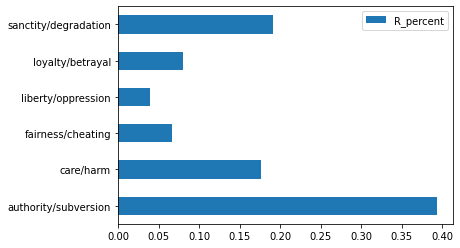

In [52]:
# your code here
avg_rep_stats.plot.barh()

**Comparing the groups**

In [53]:
# we comine the avg stats on both parties using the join function .join

all_avg_stats = avg_dem_stats.join(avg_rep_stats)
all_avg_stats

D_percent  R_percent
authority/subversion   0.321495   0.393636
care/harm              0.292418   0.176955
fairness/cheating      0.082472   0.066454
liberty/oppression     0.030215   0.039025
loyalty/betrayal       0.145686   0.080041
sanctity/degradation   0.204513   0.191499

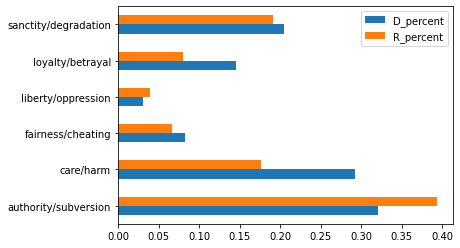

In [54]:
# we plot the avg stats for both parties 

all_avg_stats.plot.barh()

Observations

We see the bar lengths are very similar which makes it difficult to make inferences or comparison judgments on differences. 

To make clear comparisons, we create a plot of only the difference in avergae foundation word usage of Democrats and Republicans. 

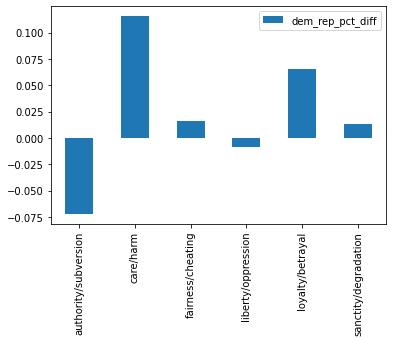

In [55]:
party_diffs = pd.DataFrame(data = avg_dem_stats['D_percent'] - avg_rep_stats['R_percent'],
                          columns = ["dem_rep_pct_diff"], 
                          index = mft_dict.keys())
party_diffs.plot.bar()

The positive value means Democracts using the word more frequently while a negative value indicates Republicans use it more frequently

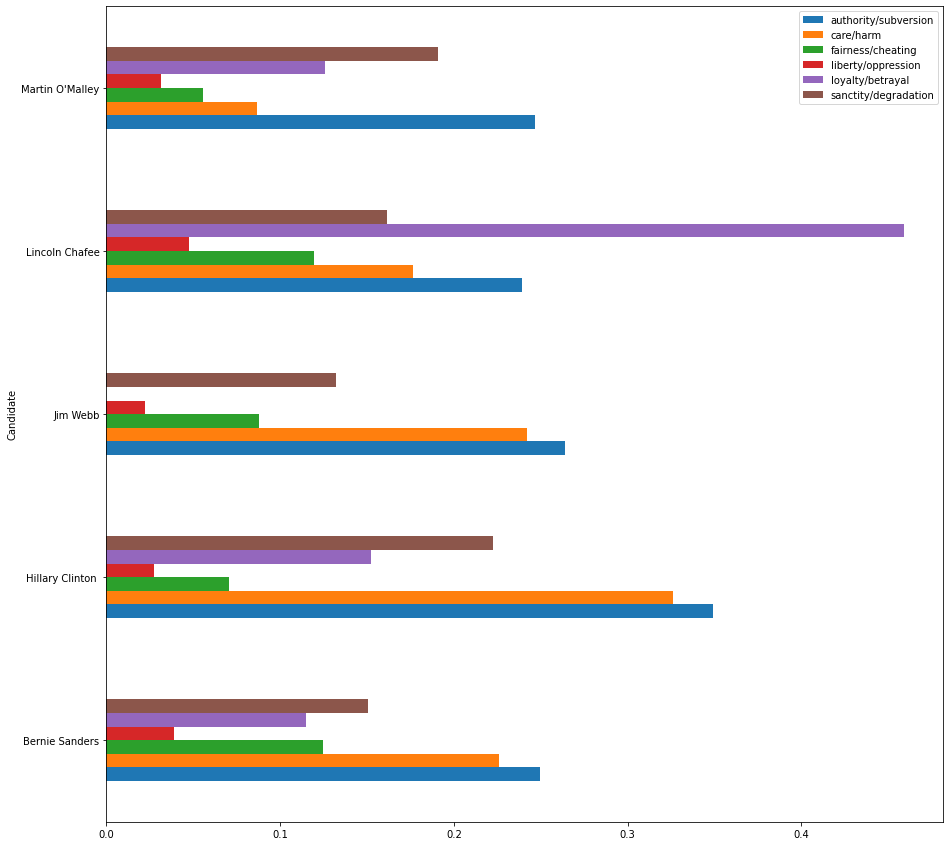

In [56]:
# We look at the candidates individually to compare the average use of foundation words by individual Democrats

dem_indivs = (democrats.loc[:, list(mft_dict.keys()) + ['Candidate']]
             .groupby('Candidate')
             .mean())

dem_indivs.plot.barh(figsize=(15, 15))

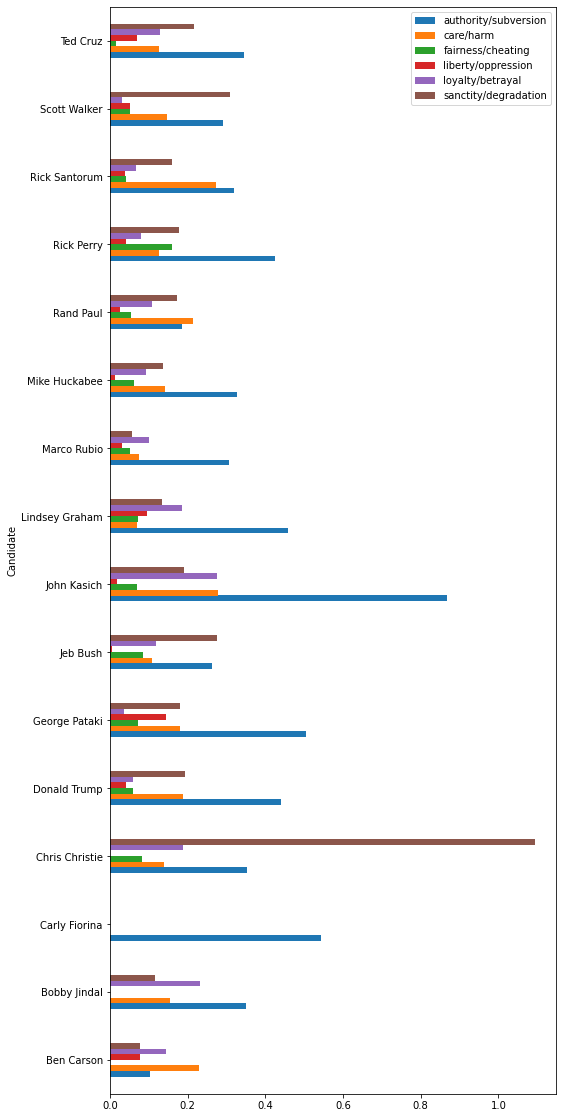

In [57]:
# and for individual republicans 

rep_indivs = (republicans.loc[:, list(mft_dict.keys()) + ['Candidate']]
             .groupby('Candidate')
             .mean())

rep_indivs.plot.barh(figsize=(8, 20))

**Incorporating temporal analysis to examine how a candidate use foundation words over time.**

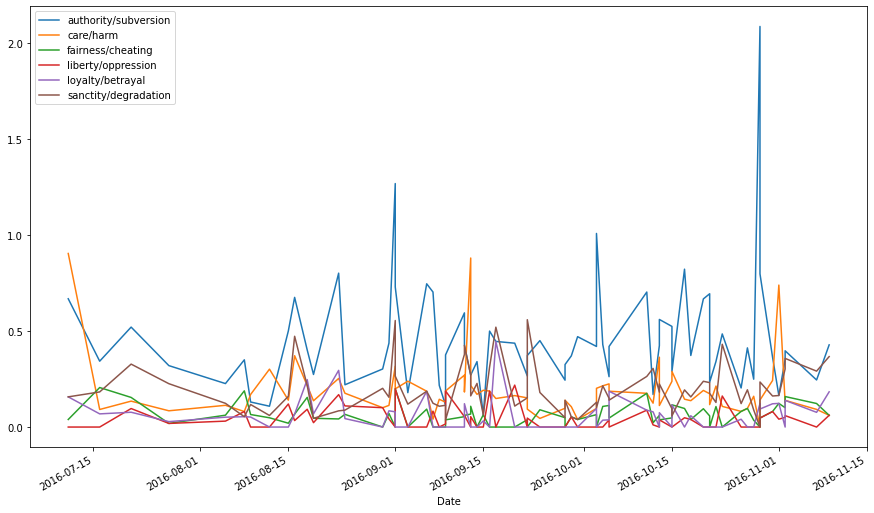

In [58]:
# Doland Trump

trump = (republicans[republicans['Candidate'] == "Donald Trump"]
         .loc[:, list(mft_dict.keys()) + ['Date']])

# set the speech dates as the table index
trump['Date'] = pd.to_datetime(trump['Date'])
trump = (trump.set_index('Date')
         .loc['2016-07-01':])

# plot the data
trump.plot(figsize = (15, 9))

# Clustering 

There seems to be two types of morality varying by candidate. Let's see which candidates fall into which morality clusters

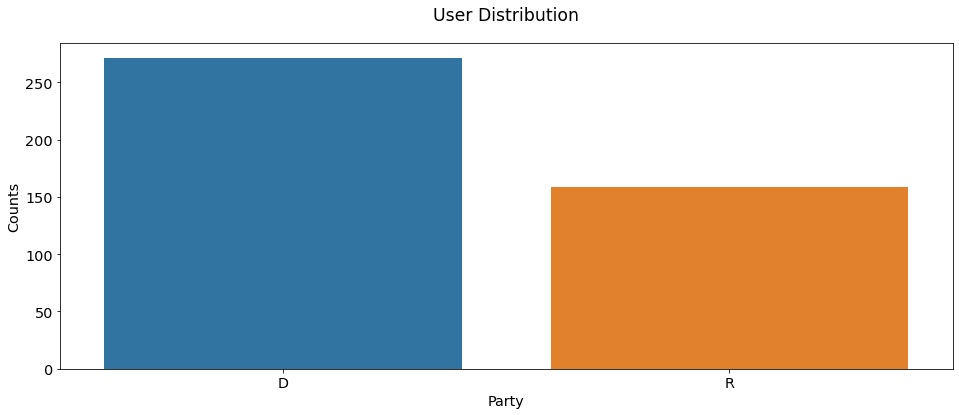

In [59]:
#let's first view our user distribution


users = campaign['Party'].unique().tolist()

users_distrib = campaign['Party'].value_counts()

plt.figure(figsize=(16, 6))
ax = sns.barplot(x=users_distrib.index, y=users_distrib.values)

plt.setp(ax.xaxis.get_label(), fontsize='x-large');
plt.setp(ax.yaxis.get_label(), fontsize='x-large');

ax.set_title("User Distribution", fontsize="xx-large", y=1.05)
ax.set_xlabel("Party", fontsize="x-large")
ax.set_ylabel("Counts", fontsize="x-large")

plt.setp(ax.get_xticklabels(), fontsize='x-large');
plt.setp(ax.get_yticklabels(), fontsize='x-large');

In [60]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import numpy as np

In [61]:
train = campaign.drop(columns=['Candidate', 'Party', 'Type',
                               'Date', 'Title', 'Text',
                               'word_count', 'sentence_count', 'avg_word_length',
                               'clean_text', 'words', 'sentences',
                               'char_count', 'avg_sentence_length', 'datetime',
                               'clean_speech', 'total_words'])
train.head()

authority/subversion  care/harm  fairness/cheating  liberty/oppression  \
0              0.175131   0.175131           0.131349            0.000000   
1              0.303260   0.075815           0.265353            0.000000   
2              0.321285   0.133869           0.026774            0.000000   
3              0.159574   0.053191           0.053191            0.000000   
4              0.313725   0.117647           0.039216            0.039216   

   loyalty/betrayal  sanctity/degradation  
0          0.306480              0.175131  
1          0.151630              0.341168  
2          0.107095              0.133869  
3          0.053191              0.212766  
4          0.000000              0.274510

In [62]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(train)

In [63]:
len(kmeans.labels_)

430

Assigning candidates to clusters

In [64]:
df_clustered = campaign

In [65]:
df_clustered['Cluster'] = kmeans.labels_
df_clustered.head()

Candidate Party    Type               Date  \
0  Jeb Bush     R  speech      June 15, 2015   
1  Jeb Bush     R  speech      July 30, 2015   
2  Jeb Bush     R  speech    August 11, 2015   
3  Jeb Bush     R  speech  September 9, 2015   
4  Jeb Bush     R  speech   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   
3  Thank you very much. I appreciate your hospita...   
4  Thank you. It's great to be in Tampa with so m...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   
3  thank you very much. i appreciate your hospita...   
4  thank you. it's great to be in tampa with so m...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   
3  [thank, you, very, much, ., i, appreciate, you...   
4  [thank, you, ., it, 's, great, to, be, in, tam...   

                                           sentences  char_count  ...  \
0  [thank you all very much., i always feel welco...       12383  ...   
1  [thank you all very much., i appreciate your h...       14457  ...   
2  [thank you very much., it's good to be with al...       21283  ...   
3  [thank you very much., i appreciate your hospi...       10049  ...   
4  [thank you., it's great to be in tampa with so...       14189  ...   

    datetime                                       clean_speech  total_words  \
0 2015-06-15  [thank, you, all, very, much, i, always, feel,...         2284   
1 2015-07-30  [thank, you, all, very, much, i, appreciate, y...         2638   
2 2015-08-11  [thank, you, very, much, it, s, good, to, be, ...         3735   
3 2015-09-09  [thank, you, very, much, i, appreciate, your, ...         1880   
4 2015-11-02  [thank, you, it, s, great, to, be, in, tampa, ...         2550   

   authority/subversion care/harm fairness/cheating  liberty/oppression  \
0              0.175131  0.175131          0.131349            0.000000   
1              0.303260  0.075815          0.265353            0.000000   
2              0.321285  0.133869          0.026774            0.000000   
3              0.159574  0.053191          0.053191            0.000000   
4              0.313725  0.117647          0.039216            0.039216   

   loyalty/betrayal  sanctity/degradation  Cluster  
0          0.306480              0.175131        0  
1          0.151630              0.341168        0  
2          0.107095              0.133869        0  
3          0.053191              0.212766        0  
4          0.000000              0.274510        0  

[5 rows x 24 columns]

Discrete cluster assignement

In [66]:
clusters = df_clustered.groupby('Candidate').Cluster.mean().round()
cluster_map = {0: "a", 1:"b"}
clusters_mapped = clusters.map(cluster_map)
clusters_mapped

Candidate
Ben Carson          a
Bernie Sanders      a
Bobby Jindal        a
Carly Fiorina       a
Chris Christie      a
Donald Trump        a
George Pataki       a
Hillary Clinton     a
Jeb Bush            a
Jim Webb            a
John Kasich         a
Lincoln Chafee      a
Lindsey Graham      a
Marco Rubio         a
Martin O'Malley     a
Mike Huckabee       a
Rand Paul           a
Rick Perry          a
Rick Santorum       a
Scott Walker        a
Ted Cruz            a
Name: Cluster, dtype: object

In [67]:
print("Candidates with morality a : \n", clusters_mapped[clusters_mapped == 'a'])

Candidates with morality a : 
 Candidate
Ben Carson          a
Bernie Sanders      a
Bobby Jindal        a
Carly Fiorina       a
Chris Christie      a
Donald Trump        a
George Pataki       a
Hillary Clinton     a
Jeb Bush            a
Jim Webb            a
John Kasich         a
Lincoln Chafee      a
Lindsey Graham      a
Marco Rubio         a
Martin O'Malley     a
Mike Huckabee       a
Rand Paul           a
Rick Perry          a
Rick Santorum       a
Scott Walker        a
Ted Cruz            a
Name: Cluster, dtype: object


In [68]:
print("Candidates with morality b : \n", clusters_mapped[clusters_mapped == 'b'])

Candidates with morality b : 
 Series([], Name: Cluster, dtype: object)


Assigning continuous values based on mean of cluster class

In [69]:
cluster_cont = df_clustered.groupby('Candidate').Cluster.mean()
result = pd.DataFrame({"candidate": cluster_cont.index, "mean_moral":cluster_cont})
result = result.sort_values(by=['mean_moral'])
result

candidate  mean_moral
Candidate                                     
Ben Carson              Ben Carson    0.000000
Rick Perry              Rick Perry    0.000000
Rand Paul                Rand Paul    0.000000
Mike Huckabee        Mike Huckabee    0.000000
Martin O'Malley    Martin O'Malley    0.000000
Marco Rubio            Marco Rubio    0.000000
Lindsey Graham      Lindsey Graham    0.000000
Lincoln Chafee      Lincoln Chafee    0.000000
Scott Walker          Scott Walker    0.000000
John Kasich            John Kasich    0.000000
Jeb Bush                  Jeb Bush    0.000000
George Pataki        George Pataki    0.000000
Chris Christie      Chris Christie    0.000000
Carly Fiorina        Carly Fiorina    0.000000
Bobby Jindal          Bobby Jindal    0.000000
Jim Webb                  Jim Webb    0.000000
Ted Cruz                  Ted Cruz    0.000000
Donald Trump          Donald Trump    0.040541
Bernie Sanders      Bernie Sanders    0.050000
Rick Santorum        Rick Santorum    0.100000
Hillary Clinton   Hillary Clinton     0.163265

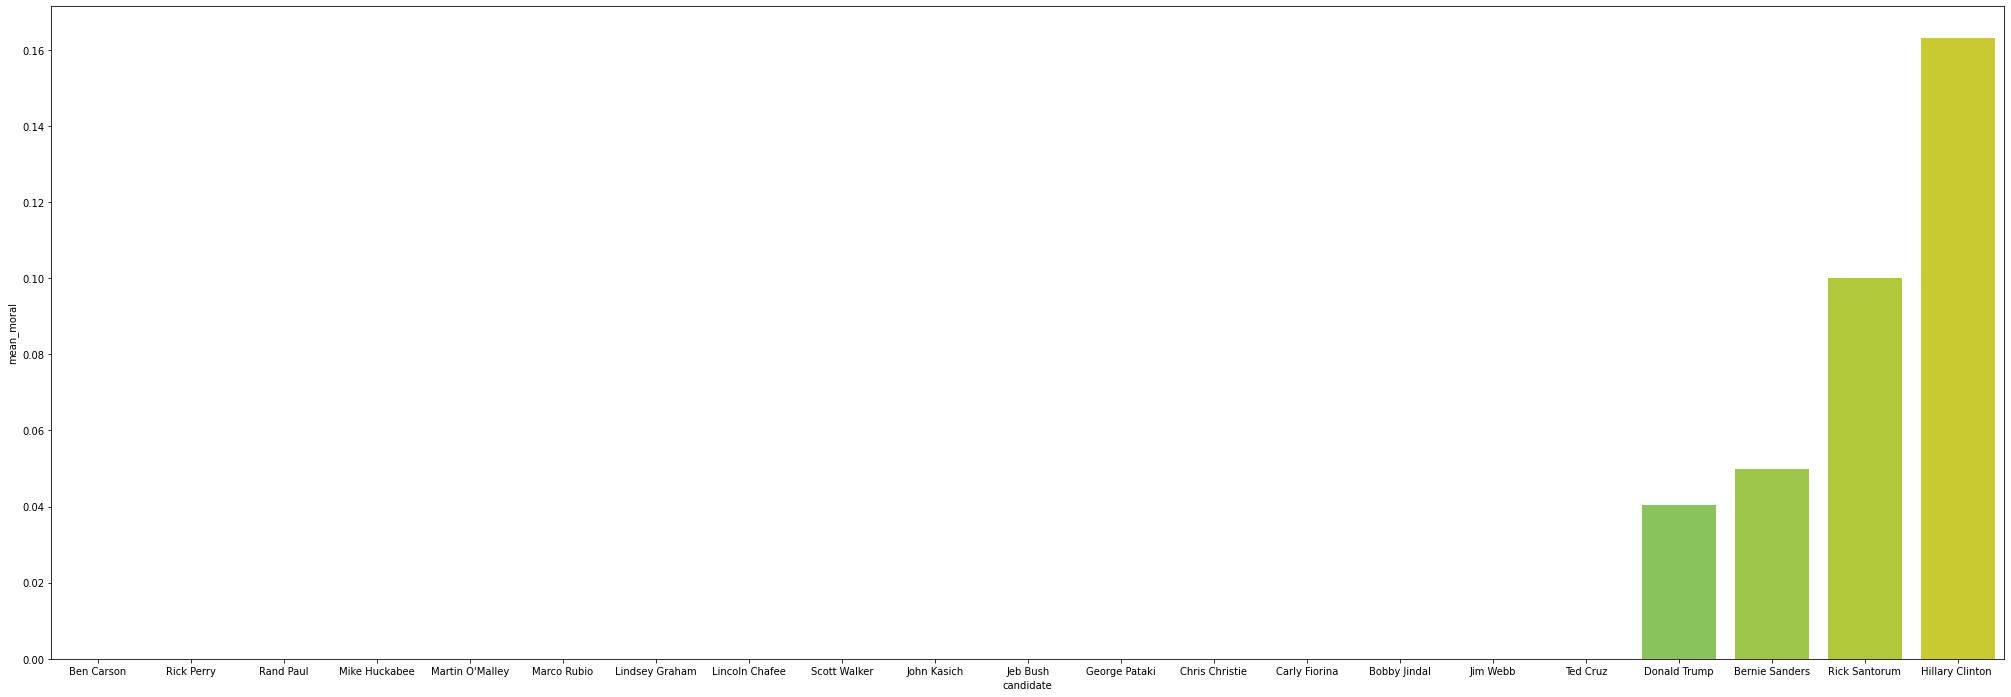

In [70]:
f, ax = plt.subplots(figsize=(35, 12))
sns.barplot(x='candidate', y='mean_moral',data=result, palette="viridis");

This represents candidates morality along a continuum from prevalence of morality a to b (not which candiates are "more moral")

# **Moral Foundations Predictive Analysis**

What are the factors associated with the change in candidate moral identity and can we predict them

# Feature Importance

In [71]:
!pip install shap 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
import shap
import pandas as pd 
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

Random Forest

In [73]:
campaign['Party'] = campaign['Party'].replace(['R','D'],['1','0'])

In [74]:
campaign['Type'] = campaign['Type'].replace(['speech','statement', 'audio'],['1','0', '2'])

In [75]:
X = train
y = campaign['Party']

In [76]:
# Split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [77]:
from sklearn.preprocessing import LabelEncoder

In [78]:
#le=LabelEncoder()
#campaign['Party']=le.fit_transform(campaign['Party'])

In [79]:
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(Xtrain, ytrain)

RandomForestRegressor()

In [80]:
rf_train = rf_reg.score(Xtrain, ytrain)
rf_cv = cross_val_score(rf_reg, Xtrain, ytrain, cv=5).mean()
rf_test = rf_reg.score(Xtest, ytest)
print('Evaluation of the Random Forest performance\n')
print(f'Training score: {rf_train.round(4)}')
print(f'Cross validation score: {rf_cv.round(4)}')
print(f'Test score: {rf_test.round(4)}')

Evaluation of the Random Forest performance

Training score: 0.8654
Cross validation score: 0.1191
Test score: 0.1461


SHAp Values

In [81]:
shap.initjs()

In [82]:
# Create SHAP explainer
explainer = shap.TreeExplainer(rf_reg)
shap_values = explainer.shap_values(X)

In [83]:
# shap force plot for the first prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [84]:
# SHAP values for all predictions
shap.force_plot(explainer.expected_value, shap_values, X)

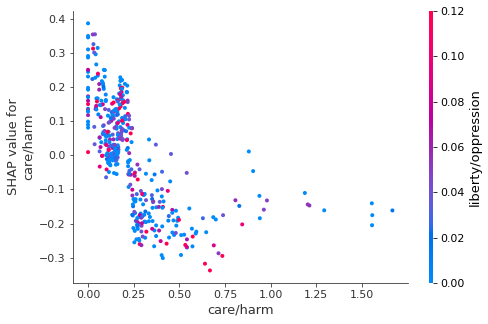

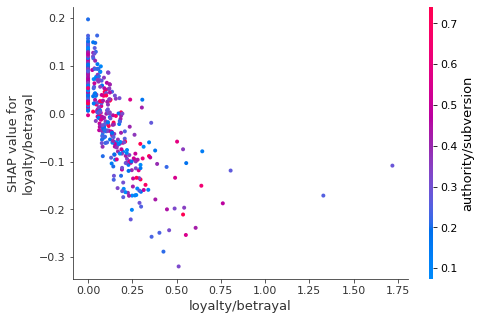

In [85]:
# Effect of a single feature on the shap value,and automatically selected other feature to show dependence 
shap.dependence_plot('care/harm', shap_values, X)
shap.dependence_plot('loyalty/betrayal', shap_values, X)

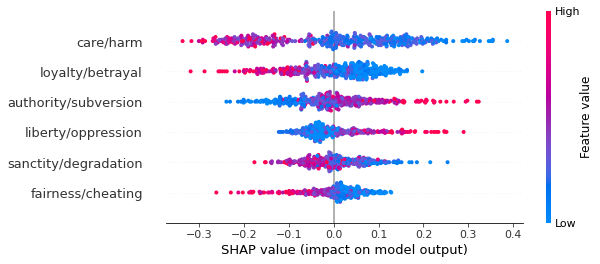

In [86]:
# See how every feaure contributes to the model output
shap.summary_plot(shap_values, X)

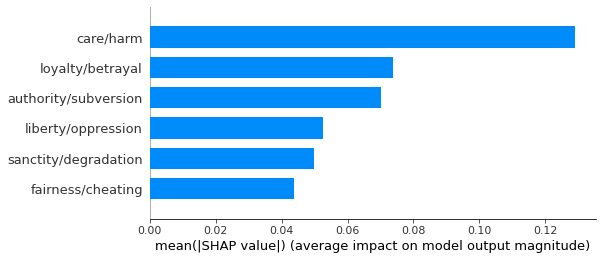

In [87]:
shap.summary_plot(shap_values, X, plot_type="bar")

# Machine Learning

Given that each user has an attribute score on each of the foundation features, we apply machine learning algorthims below to predict the candidate party. 

In [88]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import datetime
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [89]:
campaign.head()

Candidate Party Type               Date  \
0  Jeb Bush     1    1      June 15, 2015   
1  Jeb Bush     1    1      July 30, 2015   
2  Jeb Bush     1    1    August 11, 2015   
3  Jeb Bush     1    1  September 9, 2015   
4  Jeb Bush     1    1   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   
3  Thank you very much. I appreciate your hospita...   
4  Thank you. It's great to be in Tampa with so m...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   
3  thank you very much. i appreciate your hospita...   
4  thank you. it's great to be in tampa with so m...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   
3  [thank, you, very, much, ., i, appreciate, you...   
4  [thank, you, ., it, 's, great, to, be, in, tam...   

                                           sentences  char_count  ...  \
0  [thank you all very much., i always feel welco...       12383  ...   
1  [thank you all very much., i appreciate your h...       14457  ...   
2  [thank you very much., it's good to be with al...       21283  ...   
3  [thank you very much., i appreciate your hospi...       10049  ...   
4  [thank you., it's great to be in tampa with so...       14189  ...   

    datetime                                       clean_speech  total_words  \
0 2015-06-15  [thank, you, all, very, much, i, always, feel,...         2284   
1 2015-07-30  [thank, you, all, very, much, i, appreciate, y...         2638   
2 2015-08-11  [thank, you, very, much, it, s, good, to, be, ...         3735   
3 2015-09-09  [thank, you, very, much, i, appreciate, your, ...         1880   
4 2015-11-02  [thank, you, it, s, great, to, be, in, tampa, ...         2550   

   authority/subversion care/harm fairness/cheating  liberty/oppression  \
0              0.175131  0.175131          0.131349            0.000000   
1              0.303260  0.075815          0.265353            0.000000   
2              0.321285  0.133869          0.026774            0.000000   
3              0.159574  0.053191          0.053191            0.000000   
4              0.313725  0.117647          0.039216            0.039216   

   loyalty/betrayal  sanctity/degradation  Cluster  
0          0.306480              0.175131        0  
1          0.151630              0.341168        0  
2          0.107095              0.133869        0  
3          0.053191              0.212766        0  
4          0.000000              0.274510        0  

[5 rows x 24 columns]

In [90]:
campaign['Party'].unique()

array(['1', '0'], dtype=object)

Exploratory Data Visualization

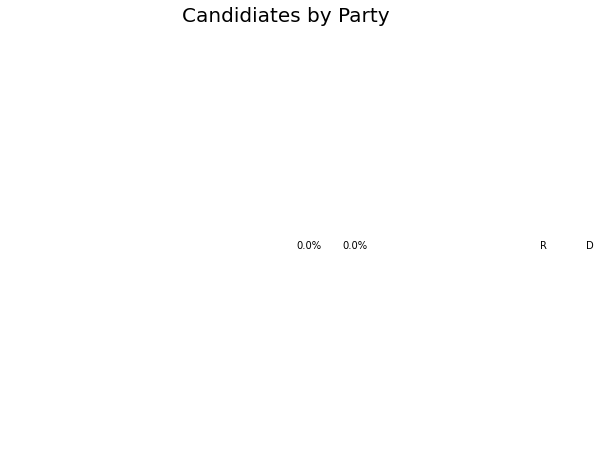

In [91]:
labels = 'R', 'D'
sizes = [campaign.Party[campaign['Party']==1].count(), campaign.Party[campaign['Party']==0].count()]
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=(0, 0.1), labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Candidiates by Party", size = 20)
plt.show()

i. Categorical Variables

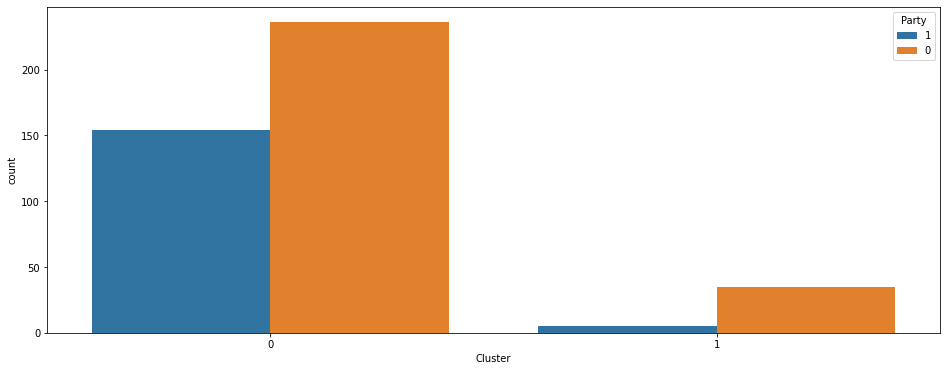

In [92]:
fig = plt.figure(figsize=(16, 6))
sns.countplot(x='Cluster', hue = 'Party',data = campaign)

plt.show()

ii. Continuous Variables

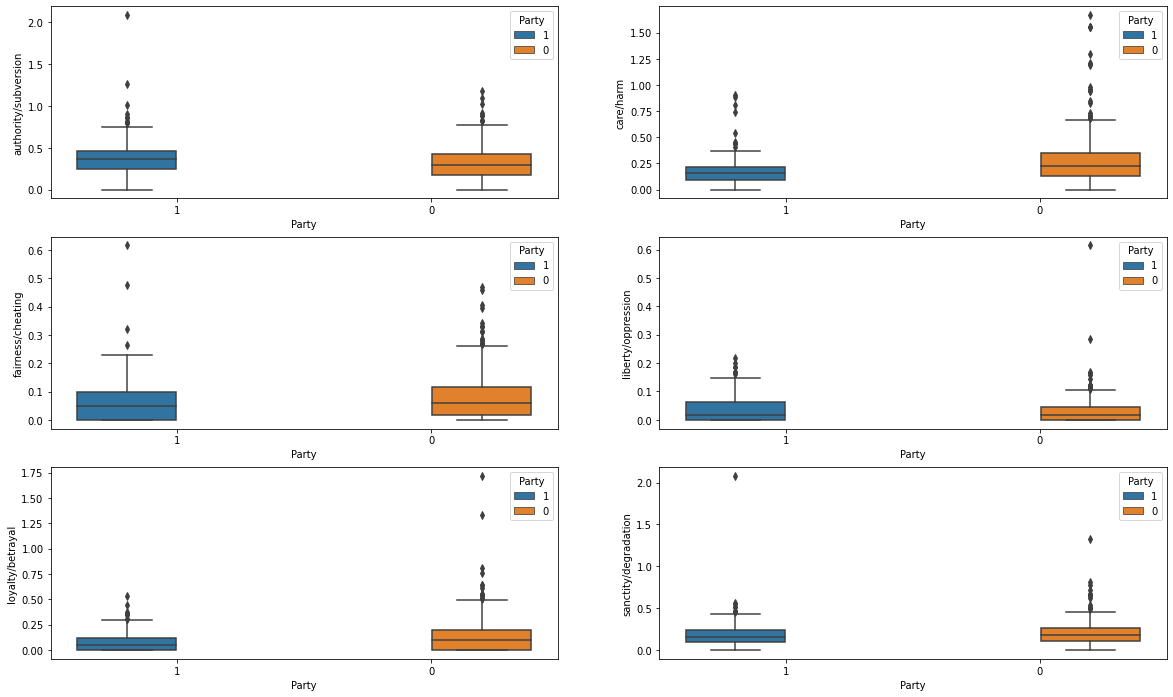

In [93]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='authority/subversion',x = 'Party', hue = 'Party',data = campaign, ax=axarr[0][0])
sns.boxplot(y='care/harm',x = 'Party', hue = 'Party',data = campaign , ax=axarr[0][1])
sns.boxplot(y='fairness/cheating',x = 'Party', hue = 'Party',data = campaign, ax=axarr[1][0])
sns.boxplot(y='liberty/oppression',x = 'Party', hue = 'Party',data = campaign, ax=axarr[1][1])
sns.boxplot(y='loyalty/betrayal',x = 'Party', hue = 'Party',data = campaign, ax=axarr[2][0])
sns.boxplot(y='sanctity/degradation',x = 'Party', hue = 'Party',data = campaign, ax=axarr[2][1])

Inferences: 

There is no significant differences in the authority/subversion ndistribution and the political party of the candidate

Democrat candiates are more likley to have higher care/harm scores 

Democrat candiates are more likley to have higher fairness/cheating scores 


In [94]:
campaign.head(3)

Candidate Party Type             Date  \
0  Jeb Bush     1    1    June 15, 2015   
1  Jeb Bush     1    1    July 30, 2015   
2  Jeb Bush     1    1  August 11, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   

                                           sentences  char_count  ...  \
0  [thank you all very much., i always feel welco...       12383  ...   
1  [thank you all very much., i appreciate your h...       14457  ...   
2  [thank you very much., it's good to be with al...       21283  ...   

    datetime                                       clean_speech  total_words  \
0 2015-06-15  [thank, you, all, very, much, i, always, feel,...         2284   
1 2015-07-30  [thank, you, all, very, much, i, appreciate, y...         2638   
2 2015-08-11  [thank, you, very, much, it, s, good, to, be, ...         3735   

   authority/subversion care/harm fairness/cheating  liberty/oppression  \
0              0.175131  0.175131          0.131349                 0.0   
1              0.303260  0.075815          0.265353                 0.0   
2              0.321285  0.133869          0.026774                 0.0   

   loyalty/betrayal  sanctity/degradation  Cluster  
0          0.306480              0.175131        0  
1          0.151630              0.341168        0  
2          0.107095              0.133869        0  

[3 rows x 24 columns]

iii. Split into dependent and independent variables

In [95]:
x = campaign[['authority/subversion', 'care/harm','fairness/cheating', 'liberty/oppression', 'loyalty/betrayal', 'sanctity/degradation']]
y = campaign['Party']

Normalize continuous variables using Standard Scaler

In [96]:
sc = StandardScaler()
x = sc.fit_transform(x)

Split into train and test sets

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [98]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(301, 6)
(129, 6)
(301,)
(129,)


**Apply ML Algorithms**

Logistic Regression

In [99]:
lr=LogisticRegression()
lr.fit(x_train,y_train)
lr_ypred=lr.predict(x_test)
lr_acc = sklearn.metrics.accuracy_score(lr_ypred,y_test)
print("Logistic Regression Accuracy: ")
print(lr_acc*100,"%")

Logistic Regression Accuracy: 
72.86821705426357 %


Naive Bayes

In [100]:
nb=GaussianNB()
nb.fit(x_train,y_train)
nb_ypred=nb.predict(x_test)
nb_acc = sklearn.metrics.accuracy_score(nb_ypred,y_test)
print("Naive Bayes Accuracy:")
print(nb_acc*100,"%")

Naive Bayes Accuracy:
61.240310077519375 %


Stochastic Gradient Descent

In [101]:
sgd=SGDClassifier(loss='modified_huber', shuffle=True, random_state=15)
sgd.fit(x_train,y_train)
sgd_ypred=sgd.predict(x_test)
sgd_acc = sklearn.metrics.accuracy_score(sgd_ypred,y_test)
print("Stochastic Gradient Descent Accuracy: ")
print(sgd_acc*100,"%")

Stochastic Gradient Descent Accuracy: 
62.01550387596899 %


K-Nearest Neighbours

In [102]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
knn_ypred=knn.predict(x_test)
knn_acc = sklearn.metrics.accuracy_score(knn_ypred,y_test)
print("K-Nearest Neighbour Accuracy: ")
print(knn_acc*100,"%")

K-Nearest Neighbour Accuracy: 
66.66666666666666 %


Decision Tree

In [103]:
dtree=DecisionTreeClassifier(max_depth=100,random_state=10,max_features=None, min_samples_leaf=100)
dtree.fit(x_train,y_train)
dtree_ypred=dtree.predict(x_test)
dtree_acc = sklearn.metrics.accuracy_score(dtree_ypred,y_test)
print("Decision Tree Accuracy: ")
print(dtree_acc*100,"%")

Decision Tree Accuracy: 
65.11627906976744 %


Random Forest

In [104]:
rfm=RandomForestClassifier(n_estimators=200,oob_score=True,n_jobs=-1, random_state=20,max_features=None,min_samples_leaf=2)
rfm.fit(x_train,y_train)
rfm_ypred=rfm.predict(x_test)
rfm_acc = sklearn.metrics.accuracy_score(rfm_ypred,y_test)
print("Random Forest Accuracy: ")
print(rfm_acc*100,"%")

Random Forest Accuracy: 
70.54263565891473 %


Support Vector Machine

In [105]:
svm=SVC(kernel="linear",C=0.025,random_state=None)
svm.fit(x_train,y_train)
svm_ypred=svm.predict(x_test)
svm_acc = sklearn.metrics.accuracy_score(svm_ypred,y_test)
print("Support Vector Machine Accuracy: ")
print(svm_acc*100,"%")

Support Vector Machine Accuracy: 
68.9922480620155 %


**ML Model Evaluation**

Classification Evaluation

In [106]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [107]:
targetNames=['R', 'D']
print('For LR')
print(classification_report(y_test, lr_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For Naive Bayes')
print(classification_report(y_test, nb_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For SGD')
print(classification_report(y_test, sgd_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For KNN')
print(classification_report(y_test, knn_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For Decision Tree')
print(classification_report(y_test, dtree_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For Random Forest')
print(classification_report(y_test, rfm_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For SVM')
print(classification_report(y_test, svm_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')

For LR
              precision    recall  f1-score   support

           R       0.77      0.83      0.80        84
           D       0.63      0.53      0.58        45

    accuracy                           0.73       129
   macro avg       0.70      0.68      0.69       129
weighted avg       0.72      0.73      0.72       129

-----------------------------------------------------------------
For Naive Bayes
              precision    recall  f1-score   support

           R       0.83      0.51      0.63        84
           D       0.47      0.80      0.59        45

    accuracy                           0.61       129
   macro avg       0.65      0.66      0.61       129
weighted avg       0.70      0.61      0.62       129

-----------------------------------------------------------------
For SGD
              precision    recall  f1-score   support

           R       0.71      0.70      0.71        84
           D       0.46      0.47      0.46        45

    accuracy       

In [108]:
cm_lr = confusion_matrix(y_test, lr_ypred)
print('For Logistic Regression')
print('Confusion Matrix: ')
print(cm_lr)
acc_lr = accuracy_score(y_test, lr_ypred)
pre_lr = precision_score(y_test, lr_ypred, pos_label='1')
rec_lr = recall_score(y_test, lr_ypred, pos_label='1')
f1_lr = f1_score(y_test, lr_ypred, pos_label='1')
print('Accuracy Score: ',acc_lr)
print('Precision Score: ',pre_lr)
print('Recall Score: ',rec_lr)
print('F1 Score: ',f1_lr)

For Logistic Regression
Confusion Matrix: 
[[70 14]
 [21 24]]
Accuracy Score:  0.7286821705426356
Precision Score:  0.631578947368421
Recall Score:  0.5333333333333333
F1 Score:  0.5783132530120482


In [109]:
cf_matrix = np.array([[70, 14],
                     [21, 30]])

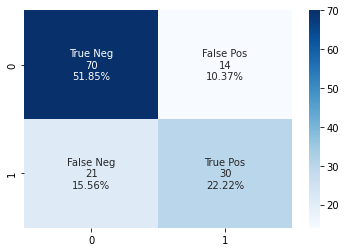

In [110]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [111]:
cm_nb = confusion_matrix(y_test, nb_ypred)
print('For Naive Bayes')
print('Confusion Matrix: ')
print(cm_nb)
acc_nb = accuracy_score(y_test, nb_ypred)
pre_nb = precision_score(y_test, nb_ypred, pos_label='1')
rec_nb = recall_score(y_test, nb_ypred, pos_label='1')
f1_nb = f1_score(y_test, nb_ypred, pos_label='1')
print('Accuracy Score: ',acc_nb)
print('Precision Score: ',pre_nb)
print('Recall Score: ',rec_nb)
print('F1 Score: ',f1_nb)

For Naive Bayes
Confusion Matrix: 
[[43 41]
 [ 9 36]]
Accuracy Score:  0.6124031007751938
Precision Score:  0.4675324675324675
Recall Score:  0.8
F1 Score:  0.5901639344262295


In [112]:
cf_matrix = np.array([[43, 41],
                     [9, 36]])

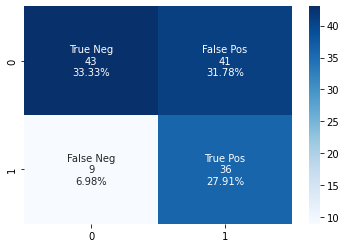

In [113]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [114]:
cm_sgd = confusion_matrix(y_test, sgd_ypred)
print('For Stochastic Gradient Descent')
print('Confusion Matrix: ')
print(cm_sgd)
acc_sgd = accuracy_score(y_test, sgd_ypred)
pre_sgd = precision_score(y_test, sgd_ypred, pos_label='1')
rec_sgd = recall_score(y_test, sgd_ypred, pos_label='1')
f1_sgd = f1_score(y_test, sgd_ypred, pos_label='1')
print('Accuracy Score: ',acc_sgd)
print('Precision Score: ',pre_sgd)
print('Recall Score: ',rec_sgd)
print('F1 Score: ',f1_sgd)

For Stochastic Gradient Descent
Confusion Matrix: 
[[59 25]
 [24 21]]
Accuracy Score:  0.6201550387596899
Precision Score:  0.45652173913043476
Recall Score:  0.4666666666666667
F1 Score:  0.46153846153846156


In [115]:
cf_matrix = np.array([[59, 25],
                     [24, 21]])

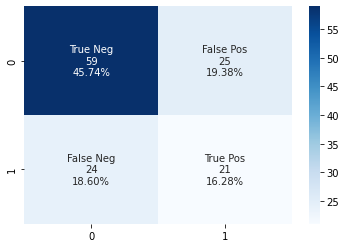

In [116]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [117]:
cm_knn = confusion_matrix(y_test, knn_ypred)
print('For KNN')
print('Confusion Matrix: ')
print(cm_knn)
acc_knn = accuracy_score(y_test, knn_ypred)
pre_knn = precision_score(y_test, knn_ypred, pos_label='1')
rec_knn = recall_score(y_test, knn_ypred, pos_label='1')
f1_knn = f1_score(y_test, knn_ypred, pos_label='1')
print('Accuracy Score: ',acc_knn)
print('Precision Score: ',pre_knn)
print('Recall Score: ',rec_knn)
print('F1 Score: ',f1_knn)

For KNN
Confusion Matrix: 
[[65 19]
 [24 21]]
Accuracy Score:  0.6666666666666666
Precision Score:  0.525
Recall Score:  0.4666666666666667
F1 Score:  0.49411764705882355


In [118]:
cf_matrix = np.array([[65, 19],
                     [24, 21]])

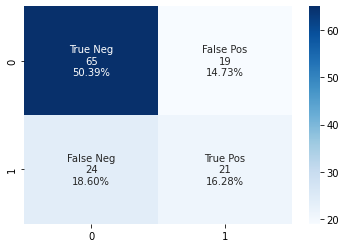

In [119]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [120]:
cm_dtree = confusion_matrix(y_test, dtree_ypred)
print('For Decision Tree')
print('Confusion Matrix: ')
print(cm_dtree)
acc_dtree = accuracy_score(y_test, dtree_ypred)
pre_dtree = precision_score(y_test, dtree_ypred, pos_label='1')
rec_dtree = recall_score(y_test, dtree_ypred, pos_label='1')
f1_dtree = f1_score(y_test, dtree_ypred, pos_label='1')
print('Accuracy Score: ',acc_dtree)
print('Precision Score: ',pre_dtree)
print('Recall Score: ',rec_dtree)
print('F1 Score: ',f1_dtree)

For Decision Tree
Confusion Matrix: 
[[84  0]
 [45  0]]
Accuracy Score:  0.6511627906976745
Precision Score:  0.0
Recall Score:  0.0
F1 Score:  0.0


In [121]:
cf_matrix = np.array([[84, 0],
                     [45, 0]])

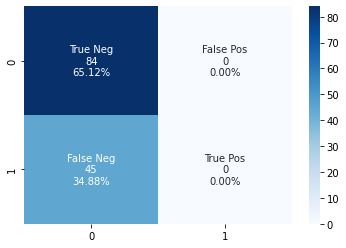

In [122]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [123]:
cm_rfm = confusion_matrix(y_test, rfm_ypred)
print('For Random Forest')
print('Confusion Matrix: ')
print(cm_rfm)
acc_rfm = accuracy_score(y_test, rfm_ypred)
pre_rfm = precision_score(y_test, rfm_ypred, pos_label='1')
rec_rfm = recall_score(y_test, rfm_ypred, pos_label='1')
f1_rfm = f1_score(y_test, rfm_ypred, pos_label='1')
print('Accuracy Score: ',acc_rfm)
print('Precision Score: ',pre_rfm)
print('Recall Score: ',rec_rfm)
print('F1 Score: ',f1_rfm)

For Random Forest
Confusion Matrix: 
[[71 13]
 [25 20]]
Accuracy Score:  0.7054263565891473
Precision Score:  0.6060606060606061
Recall Score:  0.4444444444444444
F1 Score:  0.5128205128205128


In [124]:
cf_matrix = np.array([[71, 13],
                     [25, 20]])

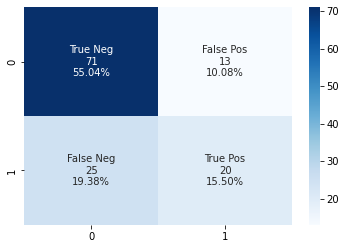

In [125]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [126]:
accuracies= {"LR": lr_acc, 
             "Naive": nb_acc, 
             "SGD": sgd_acc, 
             "kNN": knn_acc, 
             "DT": dtree_acc, 
             "RFM": rfm_acc, 
             }

precisions = {"LR": pre_lr,  
             "Naive": pre_nb, 
             "SGD": pre_sgd,
             "kNN": pre_knn, 
             "DT": pre_dtree,
            "RFM": pre_rfm,
             }

recalls = {"LR": rec_lr,  
             "Naive": rec_nb, 
             "SGD": rec_sgd,
             "kNN": rec_knn, 
             "DT": rec_dtree,
            "RFM": rec_rfm,
             }

f1s = {"LR": f1_lr,  
        "Naive": f1_nb, 
        "SGD": f1_sgd,
        "kNN": f1_knn, 
        "DT": f1_dtree,
      "RFM": f1_rfm,
        }

Classification Evaluation Metrics

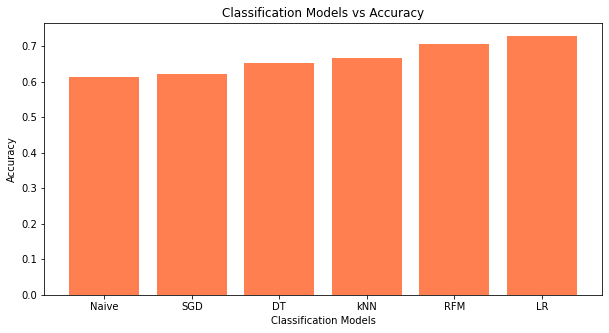

In [127]:
lists = sorted(accuracies.items(), key=lambda x: x[1]*100)
plt.figure(figsize=(10,5))
plt.bar(*zip(*lists), color="coral")
plt.title('Classification Models vs Accuracy')
plt.xlabel('Classification Models')
plt.ylabel('Accuracy')
plt.show()

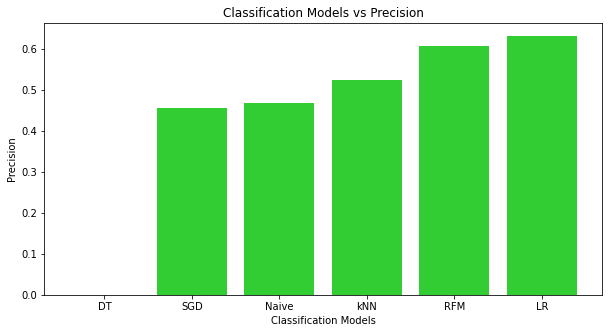

In [128]:
lists = sorted(precisions.items(), key=lambda x: x[1]*100)
plt.figure(figsize=(10,5))
plt.bar(*zip(*lists), color="limegreen")
plt.title('Classification Models vs Precision')
plt.xlabel('Classification Models')
plt.ylabel('Precision')
plt.show()

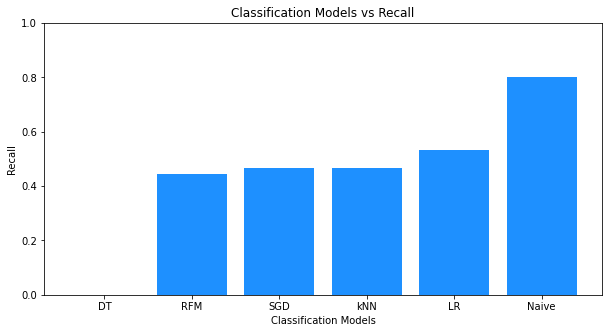

In [129]:
lists = sorted(recalls.items(), key=lambda x: x[1]*100)
plt.figure(figsize=(10,5))
plt.bar(*zip(*lists), color="dodgerblue")
plt.ylim(0,1)
plt.title('Classification Models vs Recall')
plt.xlabel('Classification Models')
plt.ylabel('Recall')
plt.show()

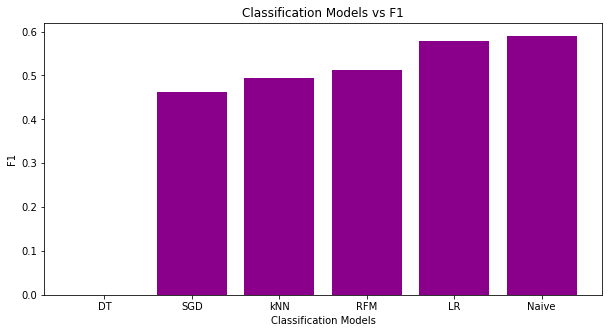

In [130]:
lists = sorted(f1s.items(), key=lambda x: x[1]*100)
plt.figure(figsize=(10,5))
plt.bar(*zip(*lists), color="darkmagenta")
plt.title('Classification Models vs F1')
plt.xlabel('Classification Models')
plt.ylabel('F1')
plt.show()

Apply Deep Learning Models

# Sentiment Analysis on the Candidates Text

In [131]:
# Import the libraries

import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import json 
import matplotlib.pyplot as plt
import datetime
plt.style.use('fivethirtyeight')

In [132]:
campaign.head()

Candidate Party Type               Date  \
0  Jeb Bush     1    1      June 15, 2015   
1  Jeb Bush     1    1      July 30, 2015   
2  Jeb Bush     1    1    August 11, 2015   
3  Jeb Bush     1    1  September 9, 2015   
4  Jeb Bush     1    1   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   
3  Thank you very much. I appreciate your hospita...   
4  Thank you. It's great to be in Tampa with so m...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   
3  thank you very much. i appreciate your hospita...   
4  thank you. it's great to be in tampa with so m...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   
3  [thank, you, very, much, ., i, appreciate, you...   
4  [thank, you, ., it, 's, great, to, be, in, tam...   

                                           sentences  char_count  ...  \
0  [thank you all very much., i always feel welco...       12383  ...   
1  [thank you all very much., i appreciate your h...       14457  ...   
2  [thank you very much., it's good to be with al...       21283  ...   
3  [thank you very much., i appreciate your hospi...       10049  ...   
4  [thank you., it's great to be in tampa with so...       14189  ...   

    datetime                                       clean_speech  total_words  \
0 2015-06-15  [thank, you, all, very, much, i, always, feel,...         2284   
1 2015-07-30  [thank, you, all, very, much, i, appreciate, y...         2638   
2 2015-08-11  [thank, you, very, much, it, s, good, to, be, ...         3735   
3 2015-09-09  [thank, you, very, much, i, appreciate, your, ...         1880   
4 2015-11-02  [thank, you, it, s, great, to, be, in, tampa, ...         2550   

   authority/subversion care/harm fairness/cheating  liberty/oppression  \
0              0.175131  0.175131          0.131349            0.000000   
1              0.303260  0.075815          0.265353            0.000000   
2              0.321285  0.133869          0.026774            0.000000   
3              0.159574  0.053191          0.053191            0.000000   
4              0.313725  0.117647          0.039216            0.039216   

   loyalty/betrayal  sanctity/degradation  Cluster  
0          0.306480              0.175131        0  
1          0.151630              0.341168        0  
2          0.107095              0.133869        0  
3          0.053191              0.212766        0  
4          0.000000              0.274510        0  

[5 rows x 24 columns]

https://github.com/joshisak/Social-Media-Network-Analysis/blob/main/Python%20Analysis/Sentiment%20Analysis%20Project.ipynb

In [133]:
# Function for cleaning the text
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    return text

# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score): # Polarity goes as a score here
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [134]:
#campaign = pd.DataFrame(Text['Text'])

campaign['text'] = campaign['Text'].apply(cleanTxt)
campaign['Subjectivity'] = campaign['Text'].apply(getSubjectivity)
campaign['Polarity'] = campaign['Text'].apply(getPolarity)
campaign['Analysis'] = campaign['Polarity'].apply(getAnalysis)
#campaign.head()

In [135]:
campaign

Candidate Party Type                Date  \
0         Jeb Bush     1    1       June 15, 2015   
1         Jeb Bush     1    1       July 30, 2015   
2         Jeb Bush     1    1     August 11, 2015   
3         Jeb Bush     1    1   September 9, 2015   
4         Jeb Bush     1    1    November 2, 2015   
...            ...   ...  ...                 ...   
7104  Donald Trump     1    1    November 9, 2016   
7389  Scott Walker     1    1       July 13, 2015   
7390  Scott Walker     1    1  September 21, 2015   
7391  Scott Walker     1    1       July 20, 2016   
7482      Jim Webb     0    1  September 24, 2015   

                                                  Title  \
0     Remarks Announcing Candidacy for President at ...   
1     Remarks to the National Urban League Conferenc...   
2     Remarks at the Ronald Reagan Presidential Libr...   
3                     Remarks in Garner, North Carolina   
4                             Remarks in Tampa, Florida   
...                                                 ...   
7104  Remarks in New York City Accepting Election as...   
7389  Remarks Announcing Candidacy for President in ...   
7390  Remarks in Madison, Wisconsin Announcing the E...   
7391  Remarks to the Republican National Convention ...   
7482  Remarks in RFD-TVs "Rural Town Hall" West Des ...   

                                                   Text  \
0     Thank you all very much. I always feel welcome...   
1     Thank you all very much. I appreciate your hos...   
2     Thank you very much. It's good to be with all ...   
3     Thank you very much. I appreciate your hospita...   
4     Thank you. It's great to be in Tampa with so m...   
...                                                 ...   
7104  Thank you. Thank you very much, everyone. [app...   
7389  I love America.As kids, my brother David and I...   
7390  As a kid, I was drawn to Ronald Reagan because...   
7391  My fellow Americans, you have a choice, you de...   
7482  OPPOLD:And from the beautiful Stine's Family B...   

                                             clean_text  \
0     thank you all very much. i always feel welcome...   
1     thank you all very much. i appreciate your hos...   
2     thank you very much. it's good to be with all ...   
3     thank you very much. i appreciate your hospita...   
4     thank you. it's great to be in tampa with so m...   
...                                                 ...   
7104  thank you. thank you very much, everyone. [app...   
7389  i love america.as kids, my brother david and i...   
7390  as a kid, i was drawn to ronald reagan because...   
7391  my fellow americans, you have a choice, you de...   
7482  oppold:and from the beautiful stine's family b...   

                                                  words  \
0     [thank, you, all, very, much, ., i, always, fe...   
1     [thank, you, all, very, much, ., i, appreciate...   
2     [thank, you, very, much, ., it, 's, good, to, ...   
3     [thank, you, very, much, ., i, appreciate, you...   
4     [thank, you, ., it, 's, great, to, be, in, tam...   
...                                                 ...   
7104  [thank, you, ., thank, you, very, much, ,, eve...   
7389  [i, love, america.as, kids, ,, my, brother, da...   
7390  [as, a, kid, ,, i, was, drawn, to, ronald, rea...   
7391  [my, fellow, americans, ,, you, have, a, choic...   
7482  [oppold, :, and, from, the, beautiful, stine, ...   

                                              sentences  char_count  ...  \
0     [thank you all very much., i always feel welco...       12383  ...   
1     [thank you all very much., i appreciate your h...       14457  ...   
2     [thank you very much., it's good to be with al...       21283  ...   
3     [thank you very much., i appreciate your hospi...       10049  ...   
4     [thank you., it's great to be in tampa with so...       14189  ...   
...                                                 ...         ...  ...   
7104

In [136]:
# Is there a negative sentiment?
sent_col = campaign['Analysis']

neg_cond = sent_col == 'Negative'

nega = campaign[neg_cond]

nega.head(10)

Candidate Party Type                Date  \
3676  Carly Fiorina     1    1         May 4, 2015   
7067   Donald Trump     1    1  September 17, 2016   
7097   Donald Trump     1    1    October 29, 2016   
7098   Donald Trump     1    1    October 29, 2016   

                                                  Title  \
3676   Video Remarks Announcing Candidacy for President   
7067  Remarks at the Remembrance Project Luncheon at...   
7097  Remarks at the Jeffco Fairgrounds Event Center...   
7098  Remarks at the Phoenix Convention Center in Ph...   

                                                   Text  \
3676  [Begins with a few seconds of Fiorina watching...   
7067  Thanks, Maria, for that introduction, and for ...   
7097  Real change also means getting rid of the corr...   
7098  The silent majority is back. In 10 days, we ar...   

                                             clean_text  \
3676  [begins with a few seconds of fiorina watching...   
7067  thanks, maria, for that introduction, and for ...   
7097  real change also means getting rid of the corr...   
7098  the silent majority is back. in 10 days, we ar...   

                                                  words  \
3676  [[, begins, with, a, few, seconds, of, fiorina...   
7067  [thanks, ,, maria, ,, for, that, introduction,...   
7097  [real, change, also, means, getting, rid, of, ...   
7098  [the, silent, majority, is, back, ., in, 10, d...   

                                              sentences  char_count  ...  \
3676  [[begins with a few seconds of fiorina watchin...        1004  ...   
7067  [thanks, maria, for that introduction, and for...        7687  ...   
7097  [real change also means getting rid of the cor...        4705  ...   
7098  [the silent majority is back., in 10 days, we ...       12205  ...   

      care/harm  fairness/cheating  liberty/oppression  loyalty/betrayal  \
3676   0.000000           0.000000            0.000000          0.000000   
7067   0.148588           0.000000            0.000000          0.445765   
7097   0.000000           0.000000            0.000000          0.122699   
7098   0.140779           0.046926            0.046926          0.093853   

     sanctity/degradation Cluster  \
3676             0.000000       0   
7067             0.520059       0   
7097             0.000000       0   
7098             0.234632       0   

                                                   text  Subjectivity  \
3676  [Begins with a few seconds of Fiorina watching...      0.360000   
7067  Thanks, Maria, for that introduction, and for ...      0.390696   
7097  Real change also means getting rid of the corr...      0.424751   
7098  The silent majority is back. In 10 days, we ar...      0.432289   

      Polarity  Analysis  
3676 -0.060000  Negative  
7067 -0.001652  Negative  
7097 -0.029903  Negative  
7098 -0.005470  Negative  

[4 rows x 28 columns]

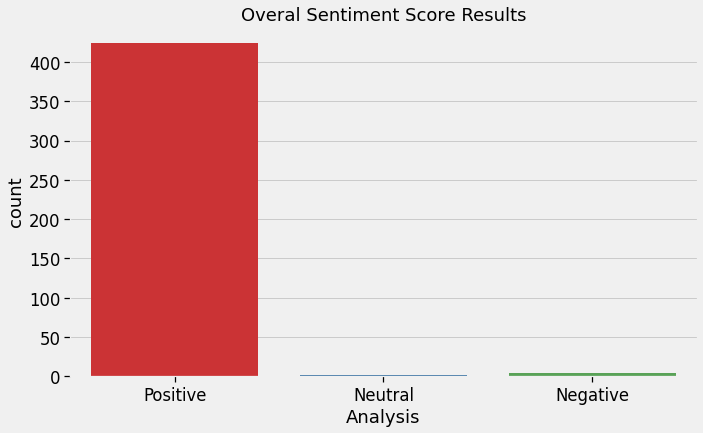

In [137]:
# Let's visualize the sentiment in our speeches dataset

plt.figure(figsize=(10,6))
sns.set_context(context='notebook', font_scale=1.5)
sns.countplot(campaign['Analysis'], palette = 'Set1')
plt.title('Overal Sentiment Score Results');

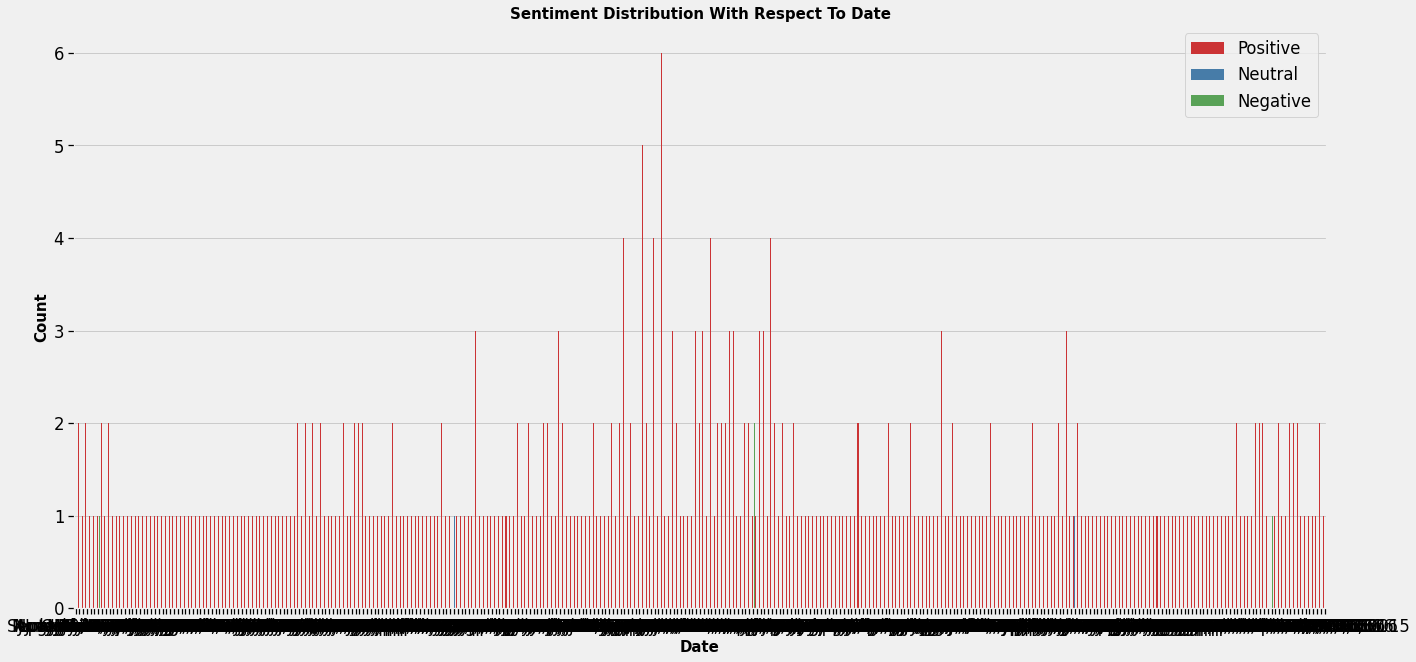

In [138]:
plt.figure(figsize=(20,10))
sns.countplot(campaign['Date'], hue=campaign['Analysis'], palette = 'Set1')
plt.legend(loc='upper right')
plt.ylabel('Count', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontsize=15, fontweight='bold')
plt.title('Sentiment Distribution With Respect To Date', fontsize=15, fontweight='bold')
plt.show()

Calculating a new sentiment score for each candidate using the agg function over pos, neg, and net. 

In [139]:
# First, we need to find the number of pos, neg, and neut for each speech 
# change pos to 1, neg to -1, and neut to 0
campaign['Analysis'] = campaign['Analysis'].replace(['Positive', 'Negative', 'Neutral'], ['1', '-1', '0'])
campaign.head()

Candidate Party Type               Date  \
0  Jeb Bush     1    1      June 15, 2015   
1  Jeb Bush     1    1      July 30, 2015   
2  Jeb Bush     1    1    August 11, 2015   
3  Jeb Bush     1    1  September 9, 2015   
4  Jeb Bush     1    1   November 2, 2015   

                                               Title  \
0  Remarks Announcing Candidacy for President at ...   
1  Remarks to the National Urban League Conferenc...   
2  Remarks at the Ronald Reagan Presidential Libr...   
3                  Remarks in Garner, North Carolina   
4                          Remarks in Tampa, Florida   

                                                Text  \
0  Thank you all very much. I always feel welcome...   
1  Thank you all very much. I appreciate your hos...   
2  Thank you very much. It's good to be with all ...   
3  Thank you very much. I appreciate your hospita...   
4  Thank you. It's great to be in Tampa with so m...   

                                          clean_text  \
0  thank you all very much. i always feel welcome...   
1  thank you all very much. i appreciate your hos...   
2  thank you very much. it's good to be with all ...   
3  thank you very much. i appreciate your hospita...   
4  thank you. it's great to be in tampa with so m...   

                                               words  \
0  [thank, you, all, very, much, ., i, always, fe...   
1  [thank, you, all, very, much, ., i, appreciate...   
2  [thank, you, very, much, ., it, 's, good, to, ...   
3  [thank, you, very, much, ., i, appreciate, you...   
4  [thank, you, ., it, 's, great, to, be, in, tam...   

                                           sentences  char_count  ...  \
0  [thank you all very much., i always feel welco...       12383  ...   
1  [thank you all very much., i appreciate your h...       14457  ...   
2  [thank you very much., it's good to be with al...       21283  ...   
3  [thank you very much., i appreciate your hospi...       10049  ...   
4  [thank you., it's great to be in tampa with so...       14189  ...   

   care/harm  fairness/cheating  liberty/oppression  loyalty/betrayal  \
0   0.175131           0.131349            0.000000          0.306480   
1   0.075815           0.265353            0.000000          0.151630   
2   0.133869           0.026774            0.000000          0.107095   
3   0.053191           0.053191            0.000000          0.053191   
4   0.117647           0.039216            0.039216          0.000000   

  sanctity/degradation Cluster  \
0             0.175131       0   
1             0.341168       0   
2             0.133869       0   
3             0.212766       0   
4             0.274510       0   

                                                text  Subjectivity  Polarity  \
0  Thank you all very much. I always feel welcome...      0.456340  0.171087   
1  Thank you all very much. I appreciate your hos...      0.449360  0.171919   
2  Thank you very much. It's good to be with all ...      0.490971  0.082839   
3  Thank you very much. I appreciate your hospita...      0.473084  0.138774   
4  Thank you. It's great to be in Tampa with so m...      0.470839  0.177264   

   Analysis  
0         1  
1         1  
2         1  
3         1  
4         1  

[5 rows x 28 columns]

In [140]:
def pos(x):
    if x['Analysis'] == 2:
        return 2
    else:
        return 0
def neut(x):
    if x['Analysis'] == 1:
        return 1
    else:
        return 0
def neg(x):
    if x['Analysis'] == 0:
        return 0
    else:
        return 0

campaign.apply(pos, axis=1)
campaign.apply(neut, axis=1)
campaign.apply(neg, axis=1)


campaign['Positive'] = campaign.apply(pos, axis=1)
campaign['Negative'] = campaign.apply(neg, axis=1)
campaign['Neutral'] = campaign.apply(neut, axis=1)

In [141]:
campaign['total_len'] = campaign['Text'].map(lambda x: len(x))
campaign['Final_Sentiment'] = round((campaign['Positive'] - campaign['Negative']) / campaign['total_len'], 2)

In [142]:
campaign

Candidate Party Type                Date  \
0         Jeb Bush     1    1       June 15, 2015   
1         Jeb Bush     1    1       July 30, 2015   
2         Jeb Bush     1    1     August 11, 2015   
3         Jeb Bush     1    1   September 9, 2015   
4         Jeb Bush     1    1    November 2, 2015   
...            ...   ...  ...                 ...   
7104  Donald Trump     1    1    November 9, 2016   
7389  Scott Walker     1    1       July 13, 2015   
7390  Scott Walker     1    1  September 21, 2015   
7391  Scott Walker     1    1       July 20, 2016   
7482      Jim Webb     0    1  September 24, 2015   

                                                  Title  \
0     Remarks Announcing Candidacy for President at ...   
1     Remarks to the National Urban League Conferenc...   
2     Remarks at the Ronald Reagan Presidential Libr...   
3                     Remarks in Garner, North Carolina   
4                             Remarks in Tampa, Florida   
...                                                 ...   
7104  Remarks in New York City Accepting Election as...   
7389  Remarks Announcing Candidacy for President in ...   
7390  Remarks in Madison, Wisconsin Announcing the E...   
7391  Remarks to the Republican National Convention ...   
7482  Remarks in RFD-TVs "Rural Town Hall" West Des ...   

                                                   Text  \
0     Thank you all very much. I always feel welcome...   
1     Thank you all very much. I appreciate your hos...   
2     Thank you very much. It's good to be with all ...   
3     Thank you very much. I appreciate your hospita...   
4     Thank you. It's great to be in Tampa with so m...   
...                                                 ...   
7104  Thank you. Thank you very much, everyone. [app...   
7389  I love America.As kids, my brother David and I...   
7390  As a kid, I was drawn to Ronald Reagan because...   
7391  My fellow Americans, you have a choice, you de...   
7482  OPPOLD:And from the beautiful Stine's Family B...   

                                             clean_text  \
0     thank you all very much. i always feel welcome...   
1     thank you all very much. i appreciate your hos...   
2     thank you very much. it's good to be with all ...   
3     thank you very much. i appreciate your hospita...   
4     thank you. it's great to be in tampa with so m...   
...                                                 ...   
7104  thank you. thank you very much, everyone. [app...   
7389  i love america.as kids, my brother david and i...   
7390  as a kid, i was drawn to ronald reagan because...   
7391  my fellow americans, you have a choice, you de...   
7482  oppold:and from the beautiful stine's family b...   

                                                  words  \
0     [thank, you, all, very, much, ., i, always, fe...   
1     [thank, you, all, very, much, ., i, appreciate...   
2     [thank, you, very, much, ., it, 's, good, to, ...   
3     [thank, you, very, much, ., i, appreciate, you...   
4     [thank, you, ., it, 's, great, to, be, in, tam...   
...                                                 ...   
7104  [thank, you, ., thank, you, very, much, ,, eve...   
7389  [i, love, america.as, kids, ,, my, brother, da...   
7390  [as, a, kid, ,, i, was, drawn, to, ronald, rea...   
7391  [my, fellow, americans, ,, you, have, a, choic...   
7482  [oppold, :, and, from, the, beautiful, stine, ...   

                                              sentences  char_count  ...  \
0     [thank you all very much., i always feel welco...       12383  ...   
1     [thank you all very much., i appreciate your h...       14457  ...   
2     [thank you very much., it's good to be with al...       21283  ...   
3     [thank you very much., i appreciate your hospi...       10049  ...   
4     [thank you., it's great to be in tampa with so...       14189  ...   
...                                                 ...         ...  ...   
7104

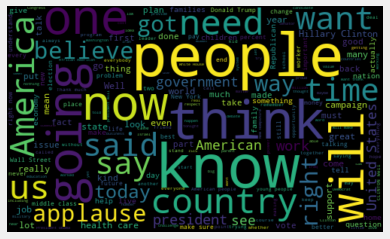

In [143]:
# word cloud visualization
allWords = ' '.join([twts for twts in campaign['Text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=80).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

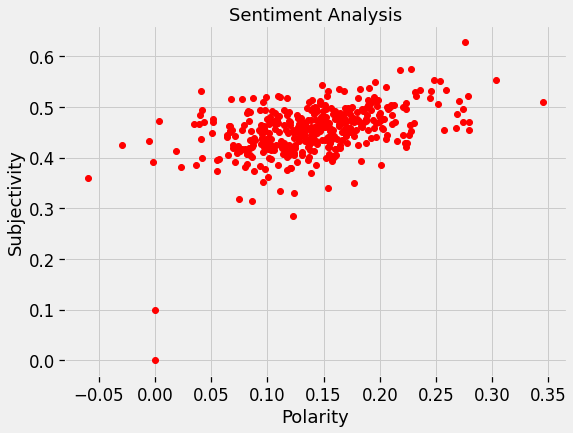

In [144]:
# Plotting polarity and subjectivity

plt.figure(figsize=(8,6)) 
plt.scatter(campaign["Polarity"], campaign["Subjectivity"], color='Red') 
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

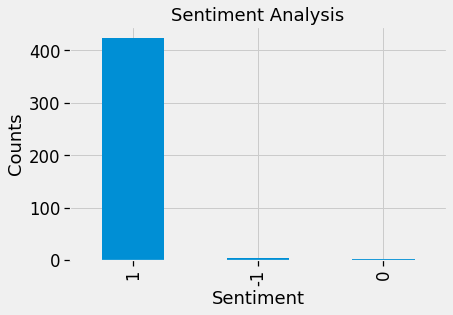

In [145]:
# Plotting and visualizing the counts

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
campaign['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

In [146]:
# final sentiment score aggrgated by candidate 

sentiment_agg = pd.pivot_table(campaign, index = ['Candidate'], aggfunc = 'mean')
sentiment_agg.reset_index(level = ['Candidate'], inplace = True)
sentiment_agg

Candidate   Cluster  Final_Sentiment  Negative  Neutral  Polarity  \
0         Ben Carson  0.000000              0.0         0        0  0.160154   
1     Bernie Sanders  0.050000              0.0         0        0  0.124630   
2       Bobby Jindal  0.000000              0.0         0        0  0.128541   
3      Carly Fiorina  0.000000              0.0         0        0 -0.060000   
4     Chris Christie  0.000000              0.0         0        0  0.075821   
5       Donald Trump  0.040541              0.0         0        0  0.102509   
6      George Pataki  0.000000              0.0         0        0  0.098545   
7   Hillary Clinton   0.163265              0.0         0        0  0.156315   
8           Jeb Bush  0.000000              0.0         0        0  0.133101   
9           Jim Webb  0.000000              0.0         0        0  0.159147   
10       John Kasich  0.000000              0.0         0        0  0.111712   
11    Lincoln Chafee  0.000000              0.0         0        0  0.132642   
12    Lindsey Graham  0.000000              0.0         0        0  0.088594   
13       Marco Rubio  0.000000              0.0         0        0  0.164463   
14   Martin O'Malley  0.000000              0.0         0        0  0.150423   
15     Mike Huckabee  0.000000              0.0         0        0  0.185990   
16         Rand Paul  0.000000              0.0         0        0  0.099780   
17        Rick Perry  0.000000              0.0         0        0  0.144127   
18     Rick Santorum  0.100000              0.0         0        0  0.164451   
19      Scott Walker  0.000000              0.0         0        0  0.209317   
20          Ted Cruz  0.000000              0.0         0        0  0.117930   

    Positive  Subjectivity  authority/subversion  avg_sentence_length  ...  \
0          0      0.526690              0.102743            17.644596  ...   
1          0      0.456581              0.249612            27.028011  ...   
2          0      0.447854              0.349786            15.951351  ...   
3          0      0.360000              0.543478            66.000000  ...   
4          0      0.508144              0.352694            18.484920  ...   
5          0      0.453704              0.440846            47.518099  ...   
6          0      0.437272              0.504141            30.525773  ...   
7          0      0.453218              0.349255            22.984024  ...   
8          0      0.456146              0.263235            66.272375  ...   
9          0      0.401073              0.264026           806.583333  ...   
10         0      0.453179              0.866898            32.083766  ...   
11         0      0.452170              0.239099            30.563725  ...   
12         0      0.467651              0.459237            22.931743  ...   
13         0      0.433049              0.306846            26.944693  ...   
14         0      0.428549              0.246645            54.006599  ...   
15         0      0.489938              0.326643            23.072594  ...   
16         0      0.449732              0.185468            24.448894  ...   
17         0      0.428823              0.424913            34.086749  ...   
18         0      0.452209              0.319741            27.050603  ...   
19         0      0.452496              0.291350            27.906981  ...   
20         0      0.446004              0.345712            30.356509  ...   

    care/harm    char_count  fairness/cheating  liberty/oppression  \
0    0.229565  13446.000000           0.000000            0.078664   
1    0.225785  16471.800000           0.124735            0.039117   
2    0.155461  13976.000000           0.000000            0.000000   
3    0.000000   1004.000000           0.000000            0.000000   
4    0.138866  14689.500000           0.082560            0.000000   
5    0.188773  18000.000000           0.060778            0.042448   
6    0.180050  15070.000000           0.072

In [147]:
sentiment_agg.describe()

Cluster  Final_Sentiment  Negative  Neutral   Polarity  Positive  \
count  21.000000             21.0      21.0     21.0  21.000000      21.0   
mean    0.016848              0.0       0.0      0.0   0.126104       0.0   
std     0.041736              0.0       0.0      0.0   0.054077       0.0   
min     0.000000              0.0       0.0      0.0  -0.060000       0.0   
25%     0.000000              0.0       0.0      0.0   0.102509       0.0   
50%     0.000000              0.0       0.0      0.0   0.132642       0.0   
75%     0.000000              0.0       0.0      0.0   0.159147       0.0   
max     0.163265              0.0       0.0      0.0   0.209317       0.0   

       Subjectivity  authority/subversion  avg_sentence_length  \
count     21.000000             21.000000            21.000000   
mean       0.450213              0.353922            69.164064   
std        0.034038              0.157611           169.570026   
min        0.360000              0.102743            15.951351   
25%        0.437272              0.263235            23.072594   
50%        0.452209              0.326643            27.906981   
75%        0.456146              0.424913            34.086749   
max        0.526690              0.866898           806.583333   

       avg_word_length  care/harm    char_count  fairness/cheating  \
count        21.000000  21.000000     21.000000          21.000000   
mean          5.016341   0.167110  15902.224647           0.063830   
std           0.213482   0.079453   8394.163493           0.040618   
min           4.625547   0.000000   1004.000000           0.000000   
25%           4.866664   0.125500  12969.500000           0.051880   
50%           4.985214   0.155461  14689.500000           0.061744   
75%           5.221132   0.225785  16471.800000           0.082560   
max           5.306098   0.326387  47284.000000           0.159444   

       liberty/oppression  loyalty/betrayal  sanctity/degradation  \
count           21.000000         21.000000             21.000000   
mean             0.039285          0.128788              0.207231   
std              0.034988          0.103593              0.214377   
min              0.000000          0.000000              0.000000   
25%              0.017464          0.066362              0.134320   
50%              0.031471          0.114917              0.171948   
75%              0.047594          0.152169              0.193221   
max              0.144040          0.458831              1.094174   

       sentence_count     total_len  total_words   word_count  
count       21.000000     21.000000    21.000000    21.000000  
mean       117.827768  15902.224647  2931.326320  3203.851415  
std         56.764389   8394.163493  1625.222567  1730.984010  
min          3.000000   1004.000000   184.000000   198.000000  
25%         75.187500  12969.500000  2362.000000  2634.300000  
50%        115.312500  14689.500000  2727.333333  2961.000000  
75%        161.500000  16471.800000  2985.316667  3337.700000  
max        228.000000  47284.000000  9090.000000  9679.000000

# Topic Modeling

(-0.5, 2999.5, 1999.5, -0.5)

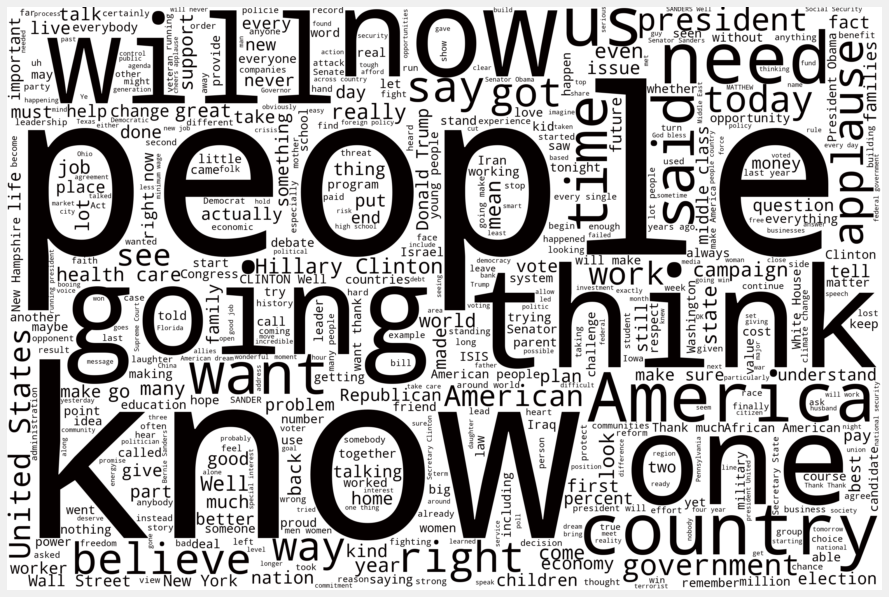

In [148]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

wordcloud = WordCloud(
                      background_color="white", width=3000, height=2000, collocations=True,
                      max_words=500, stopwords=STOPWORDS).generate_from_text(' '.join(campaign['text'].values))

# set the word color to black
wordcloud.recolor(color_func = black_color_func)
fig = plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#fig.savefig('./figures/wordcloud.png')

In [149]:
%%capture
pip install tqdm pyLDAvis gensim numpy bokeh contractions datapane

In [150]:
%load_ext autoreload
%autoreload 2

In [151]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


In [153]:
# Gensim and LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this

# NLP stuff
import contractions
#import demoji
import string
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
nltk.download('wordnet')
import spacy

# Plotting tools
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

# Miscellaneous
from sklearn.manifold import TSNE
from pprint import pprint

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [154]:
import base64
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import datapane as dp
dp.login(token="fc1a82ae5cb8f3b17c2f4975c0bd05915ce340e1")

Connected successfully to https://datapane.com as falah.amro@gmail.com


'falah.amro@gmail.com'

In [155]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Topic Modeling Prep**

Data Preprocessing


In [156]:
def sent_to_words(sentences):
    for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True)) # deacc=True removes punctuations
data_words = list(sent_to_words(campaign['text'].tolist()))
print(data_words[:1])
print("Total docs:", len(data_words))

[['thank', 'you', 'all', 'very', 'much', 'always', 'feel', 'welcome', 'at', 'miami', 'dade', 'college', 'this', 'is', 'place', 'that', 'welcomes', 'everyone', 'with', 'their', 'hearts', 'set', 'on', 'the', 'future', 'place', 'where', 'hope', 'leads', 'to', 'achievement', 'and', 'striving', 'leads', 'to', 'success', 'for', 'all', 'of', 'us', 'it', 'is', 'just', 'the', 'place', 'to', 'be', 'in', 'the', 'campaign', 'that', 'begins', 'today', 'we', 'are', 'months', 'from', 'the', 'time', 'for', 'choosing', 'the', 'stakes', 'for', 'america', 'future', 'are', 'about', 'as', 'great', 'as', 'they', 'come', 'our', 'prosperity', 'and', 'our', 'security', 'are', 'in', 'the', 'balance', 'so', 'is', 'opportunity', 'in', 'this', 'nation', 'where', 'every', 'life', 'matters', 'and', 'everyone', 'has', 'the', 'right', 'to', 'rise', 'already', 'the', 'choice', 'is', 'taking', 'shape', 'the', 'party', 'now', 'in', 'the', 'white', 'house', 'is', 'planning', 'no', 'suspense', 'primary', 'for', 'no', 'chan

In [157]:
# Build the bigram and trigram models
#Pay attention to the code below and modify as you change text input to tweet 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=25) # higher threshold fewer phrases. May need to change this to make it appropriate for tweet text length
trigram = gensim.models.Phrases(bigram[data_words], min_count=5, threshold=40)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [158]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [159]:
stop_words = stopwords.words('english')

In [160]:
data_no_stopwords = remove_stopwords(data_words)
data_bigrams = make_bigrams(data_no_stopwords)
data_preprocessed = make_trigrams(data_bigrams)
print(*data_preprocessed[:20], sep='\n')

['thank', 'much', 'always', 'feel', 'welcome', 'miami', 'dade', 'college', 'place', 'welcomes', 'everyone', 'hearts', 'set', 'future', 'place', 'hope', 'leads', 'achievement', 'striving', 'leads', 'success', 'us', 'place', 'campaign', 'begins', 'today', 'months', 'time', 'choosing', 'stakes', 'america', 'future', 'great', 'come', 'prosperity', 'security', 'balance', 'opportunity', 'nation', 'every', 'life', 'matters', 'everyone', 'right', 'rise', 'already', 'choice', 'taking', 'shape', 'party', 'white_house', 'planning', 'suspense', 'primary', 'change', 'election', 'hold', 'onto', 'power', 'slog', 'agenda', 'another', 'name', 'opponents', 'call', 'action', 'time', 'around', 'got', 'left', 'know', 'america_deserves_better', 'offered', 'progressive', 'agenda', 'includes', 'everything', 'progress', 'responsible', 'slowest', 'economic', 'recovery', 'ever', 'biggest', 'debt', 'increases', 'ever', 'massive', 'tax', 'increase', 'middle_class', 'relentless', 'buildup', 'regulatory', 'state', '

Dictionary & Corpu

In [161]:
# Create dictionary and corpus needed for topic modeling

# dictionary is a mapping of word_id --> word, as the variable name implies
id2word = corpora.Dictionary(data_preprocessed)
id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# the preprocessed and lemmatized documents themselves
texts = data_preprocessed

# corpus is a mapping of word_id --> word frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 4), (48, 4), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 2), (55, 1), (56, 2), (57, 3), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 5), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 2), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [162]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abroad', 1),
  ('accept', 2),
  ('achieve', 1),
  ('achievement', 2),
  ('act', 1),
  ('action', 1),
  ('administration', 1),
  ('adults', 1),
  ('agenda', 3),
  ('ages', 1),
  ('ago', 1),
  ('ahead', 2),
  ('alive', 1),
  ('alliances', 2),
  ('along', 1),
  ('already', 1),
  ('amendment', 1),
  ('among', 1),
  ('anyone', 1),
  ('asking', 1),
  ('attention', 1),
  ('attitude', 1),
  ('automatically', 1),
  ('bad', 1),
  ('balance', 1),
  ('baltimore', 1),
  ('beginning', 1),
  ('begins', 2),
  ('beliefs', 2),
  ('beyond', 1),
  ('biggest', 1),
  ('billion_dollars', 1),
  ('blessed', 1),
  ('bond', 1),
  ('border', 1),
  ('born', 1),
  ('boy', 1),
  ('boys', 1),
  ('brave', 1),
  ('brother', 1),
  ('brought', 3),
  ('bureaucracy', 1),
  ('bureaucrats', 1),
  ('bush', 1),
  ('businesses', 1),
  ('calling', 1),
  ('campaigns', 1),
  ('candidate', 4),
  ('capital', 4),
  ('caring', 1),
  ('case', 1),
  ('causing', 1),
  ('certain', 1),
  ('challenge', 2),
  ('challenges', 2),
  ('chang

**Latent Dirichlet Allocation (LDA)**

In [163]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Model Evaluation Metrics

In [164]:
from gensim.models import CoherenceModel

# Compute Perplexity (lower is better)
print('Perplexity: ', round(lda_model.log_perplexity(corpus), 2))

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_preprocessed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

Perplexity:  -7.72
Coherence Score:  0.48


LDA Mallet Model


In [165]:
lda_model = gensim.models.ldamodel.LdaModel(
   corpus=corpus, id2word=id2word, num_topics=20, random_state=10, 
   update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [166]:
# Show Topics
pprint(lda_model.show_topics(formatted=False)[:3])

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=lda_model, texts=data_preprocessed, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score: ', round(coherence_ldamallet, 2))

[(3,
  [('homes', 0.00027196098),
   ('ready', 0.00027196098),
   ('faith', 0.00027196095),
   ('administration', 0.00027196095),
   ('challenges', 0.00027196095),
   ('costs', 0.00027196095),
   ('security', 0.00027196092),
   ('school', 0.00027196092),
   ('patients', 0.00027196092),
   ('experience', 0.00027196092)]),
 (0,
  [('rose', 0.00027196147),
   ('troops', 0.00027196103),
   ('administration', 0.000271961),
   ('tax', 0.00027196098),
   ('challenges', 0.00027196095),
   ('problem', 0.00027196095),
   ('security', 0.00027196095),
   ('infrastructure', 0.00027196092),
   ('begin', 0.00027196092),
   ('often', 0.00027196092)]),
 (2,
  [('tonight', 0.00027196098),
   ('applause', 0.00027196098),
   ('troops', 0.00027196095),
   ('iowa', 0.00027196092),
   ('ready', 0.00027196092),
   ('students', 0.00027196092),
   ('homes', 0.00027196092),
   ('challenges', 0.00027196092),
   ('leave', 0.00027196092),
   ('military', 0.00027196092)])]
Coherence Score:  0.35


Find most optimal number of topics


In [167]:
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.models import CoherenceModel

In [168]:
from gensim.models.wrappers import LdaMallet

**TOPIC MODELING: A new Approach**

In [169]:
import re
import nltk
import string
import pyLDAvis
from pprint import pprint
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
#from bertopic import BERTopic
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamodel import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore" , category=DeprecationWarning)
pyLDAvis.enable_notebook()
tqdm.pandas()
plt.style.use("ggplot")

In [170]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [171]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 7482
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Candidate             430 non-null    object        
 1   Party                 430 non-null    object        
 2   Type                  430 non-null    object        
 3   Date                  430 non-null    object        
 4   Title                 430 non-null    object        
 5   Text                  430 non-null    object        
 6   clean_text            430 non-null    object        
 7   words                 430 non-null    object        
 8   sentences             430 non-null    object        
 9   char_count            430 non-null    int64         
 10  word_count            430 non-null    int64         
 11  sentence_count        430 non-null    int64         
 12  avg_word_length       430 non-null    float64       
 13  avg_sentence_length

In [172]:
campaign = campaign.astype({"Title": str})

In [201]:
campaign["clean_text"] = campaign["Title"]

In [202]:
#campaign.head()

In [175]:
campaign['Title'][0]

'Remarks Announcing Candidacy for President at Miami Dade College in Miami, Florida'

In [176]:
campaign['clean_text'][0]

'Remarks Announcing Candidacy for President at Miami Dade College in Miami, Florida'

Wordcloud

In [177]:
stopwords = nltk.corpus.stopwords.words('english')

In [178]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 12).generate(' '.join(topic for topic in campaign['clean_text']))

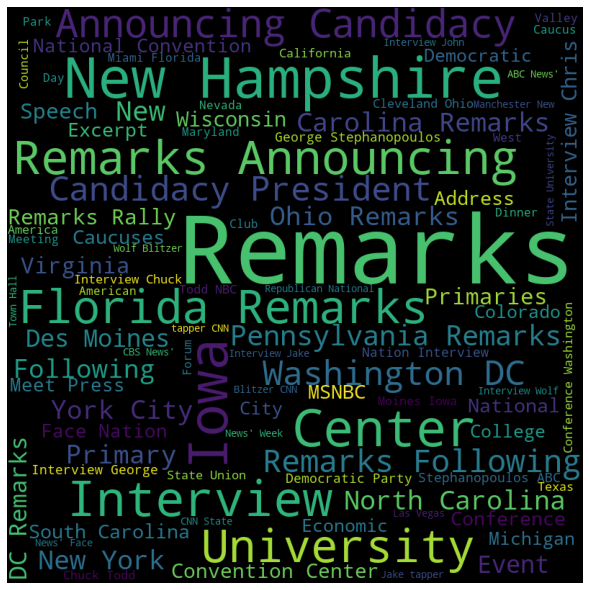

In [179]:
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

based on the wordcloud shown above we can extend our stopwords list to include some other words.



In [180]:
stopwords.extend(['New', 'Remarks', 'Announcing', 'Center', 'Primary', 'Interview', 'Washington DC', 
                  'Conference', 'Candidacy', 'President'])

Text preprocessing

In [181]:
def tokenize(text_string):
  return word_tokenize(text_string)

def remove_punct(text):
    text  = [''.join(filter( lambda x: x in 'abcdefghijklmnopqrstuvwxyz', word.lower()))
             for word in text]
    return text

def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text


def stemming(text):
    stemm = nltk.PorterStemmer()
    text = [stemm.stem(word) for word in text]
    return text


def lemmatizer(text):
    lemm = nltk.WordNetLemmatizer()
    text = [lemm.lemmatize(word) for word in text]
    return text

def clean_text(text):
  text = tokenize(text)
  text = remove_punct(text)
  # text = stemming(text)
  text = remove_stopwords(text)

  return text

In [182]:
cleaned_text_data = [ x for x in campaign['Text'].progress_apply(clean_text)]

  0%|          | 0/430 [00:00<?, ?it/s]

LDA

At first, We create a Bag of Words (BOW) dictionary from the cleaned and processed docs containing the number of times a word appears in the training set.


In [183]:
id2word = Dictionary(cleaned_text_data)
corpus = [id2word.doc2bow(text) for text in cleaned_text_data]

In [184]:
len(corpus)

430

In [185]:
#explore some terms generated from bow
[(id2word[id], freq) for id, freq in corpus[0]][:20]

[('', 177),
 ('abroad', 1),
 ('accept', 2),
 ('achieve', 1),
 ('achievement', 2),
 ('across', 1),
 ('act', 1),
 ('action', 1),
 ('administration', 1),
 ('adults', 1),
 ('againafter', 1),
 ('againwe', 1),
 ('agenda', 3),
 ('ages', 1),
 ('ago', 2),
 ('ahead', 2),
 ('alive', 1),
 ('alli', 1),
 ('alliances', 2),
 ('allwhat', 1)]

Baseline LDA model

In [186]:
#We build the baseline lda model with number of topic = 20
num_topics = 20
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=num_topics)

In [187]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.176*"" + 0.009*"nt" + 0.006*"people" + 0.005*"country" + 0.005*"going" + '
  '0.005*"president" + 0.005*"want" + 0.005*"one" + 0.004*"america" + '
  '0.004*"us"'),
 (1,
  '0.011*"" + 0.001*"nt" + 0.001*"america" + 0.001*"must" + 0.001*"american" + '
  '0.001*"us" + 0.000*"united" + 0.000*"security" + 0.000*"people" + '
  '0.000*"president"'),
 (2,
  '0.172*"" + 0.007*"nt" + 0.007*"people" + 0.005*"know" + 0.005*"country" + '
  '0.005*"president" + 0.005*"going" + 0.005*"make" + 0.004*"want" + '
  '0.004*"one"'),
 (3,
  '0.026*"" + 0.002*"people" + 0.002*"nt" + 0.002*"country" + '
  '0.002*"president" + 0.001*"need" + 0.001*"know" + 0.001*"american" + '
  '0.001*"america" + 0.001*"us"'),
 (4,
  '0.191*"" + 0.009*"nt" + 0.009*"people" + 0.006*"know" + 0.006*"going" + '
  '0.006*"country" + 0.005*"us" + 0.005*"one" + 0.005*"think" + '
  '0.005*"clinton"'),
 (5,
  '0.084*"" + 0.004*"people" + 0.004*"nt" + 0.003*"country" + 0.003*"need" + '
  '0.003*"us" + 0.003*"president" + 0.00

Get model with optimum number of topics

In [188]:
def find_optim_num_topic(dictionary , corpus , text , max=29 , start = 5 , step = 2):
    
    max_cohernce = 0
    best_model = 0
    coherence_values = []
    optim_num_topics = 0
    for num_topics in tqdm(range(start , max , step)):
        model =  LdaModel(corpus=corpus,
                          id2word=id2word,
                          num_topics=num_topics,
                          update_every=1)
        

        coherencemodel = CoherenceModel(model=model , 
                                        texts=text , 
                                        dictionary=dictionary , 
                                        coherence='c_v')
        
        coherence_value = coherencemodel.get_coherence()
        if coherence_value > max_cohernce:
          max_cohernce = coherence_value
          best_model = model
          optim_num_topics = num_topics

        coherencemodel = CoherenceModel(model=model , texts=text , dictionary=dictionary , coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"With num_topics={num_topics}, The coherence_value={coherence_value}")
    print(f"Return best model with num_topics={optim_num_topics} and max coherence_value={max_cohernce:.2f}")
    return best_model , coherence_values

In [189]:
best_model, coherence_values = find_optim_num_topic(dictionary=id2word , corpus=corpus , text=cleaned_text_data)

  0%|          | 0/12 [00:00<?, ?it/s]

With num_topics=5, The coherence_value=0.25312436954710577
With num_topics=7, The coherence_value=0.25435630459463726
With num_topics=9, The coherence_value=0.25581693509631964
With num_topics=11, The coherence_value=0.24912143557367517
With num_topics=13, The coherence_value=0.25392845843261336
With num_topics=15, The coherence_value=0.24835860712964872
With num_topics=17, The coherence_value=0.2474582396658593
With num_topics=19, The coherence_value=0.2541532105054119
With num_topics=21, The coherence_value=0.2519235974709359
With num_topics=23, The coherence_value=0.2490083230620889
With num_topics=25, The coherence_value=0.2481468708811925
With num_topics=27, The coherence_value=0.2511376352622215
Return best model with num_topics=9 and max coherence_value=0.26


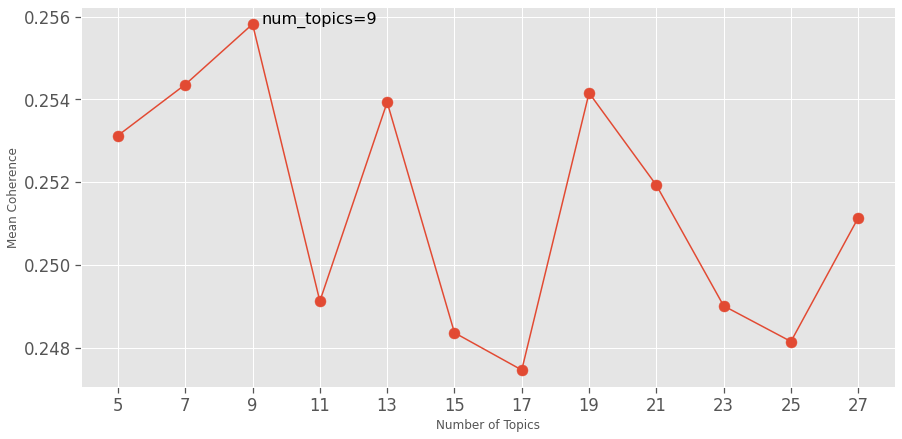

In [190]:
fig = plt.figure(figsize=(13,7))
# create the line plot
k_values = range(5 , 29 , 2)
ax = plt.plot( k_values, coherence_values )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherence_values, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherence_values)
xpos = coherence_values.index(ymax)
best_k = k_values[xpos]
plt.annotate( "num_topics=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

Visulize the model


In [191]:
LDAvis= gensimvis.prepare(best_model, corpus, id2word)

In [192]:
LDAvis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.102742  0.003551  1       1        68.941970
5      0.090494  0.001197  2       1        20.660311
7      0.073575 -0.006166  3       1        10.035431
4      0.033283 -0.001087  4       1        0.332536 
8      0.014849  0.002310  5       1        0.005952 
2     -0.027919  0.004643  6       1        0.005951 
1     -0.043980 -0.005102  7       1        0.005950 
0     -0.096554 -0.000333  8       1        0.005950 
6     -0.146491  0.000986  9       1        0.005949 , topic_info=          Term           Freq          Total Category  logprob  loglift
0               177615.000000  177615.000000  Default  30.0000  30.0000
456  nt         6483.000000    6483.000000    Default  29.0000  29.0000
492  people     7141.000000    7141.000000    Default  28.0000  28.0000
273  going      5711.000000    5711.000000    Default  27.0000  27.0000
357  know       5460.000000    5460.000000    Default  26.0000  26.0000
..    ...               ...            ...        ...      ...      ...
357  know       0.043886       5460.804844    Topic9  -6.9978  -2.0018 
678  think      0.038562       3592.520533    Topic9  -7.1271  -1.7124 
436  need       0.033310       2434.257570    Topic9  -7.2735  -1.4696 
582  said       0.032206       2492.454403    Topic9  -7.3072  -1.5270 
514  president  0.032627       3369.150412    Topic9  -7.2942  -1.8154 

[749 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
0      1      0.719144       
0      2      0.196830       
0      3      0.081677       
0      4      0.002252       
0      5      0.000034       
...   ..           ... ..    
760    1      0.664097  young
760    2      0.197555  young
760    3      0.133936  young
760    4      0.003348  young
19757  1      0.787169  yup  

[758 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 8, 5, 9, 3, 2, 1, 7])

Map docoments to topics

In [193]:
campaign['lda_topic'] = [best_model.get_document_topics(x)[0][0] for x in tqdm(corpus)]

  0%|          | 0/430 [00:00<?, ?it/s]

In [203]:
#campaign.head(1)

Count of dataset Documents in each topic

Text(0.5, 1.0, 'Number of documents per topic in the data')

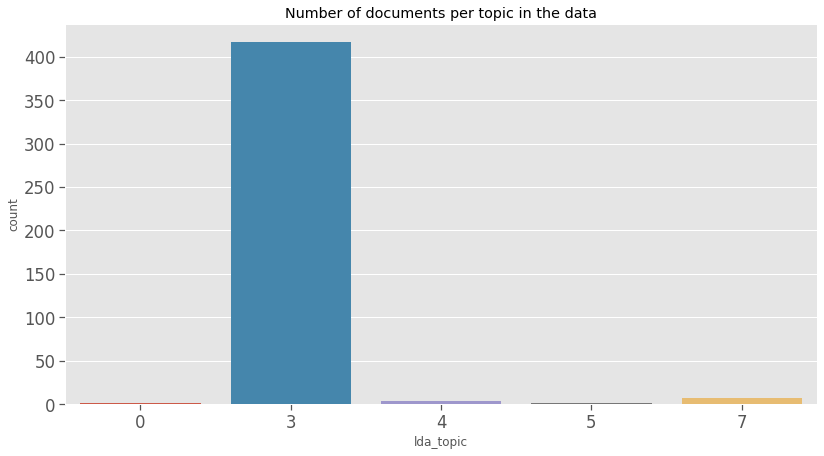

In [195]:
plt.figure(figsize=(12, 7))
import seaborn as sns
sns.countplot(campaign['lda_topic'])
plt.title("Number of documents per topic in the data")

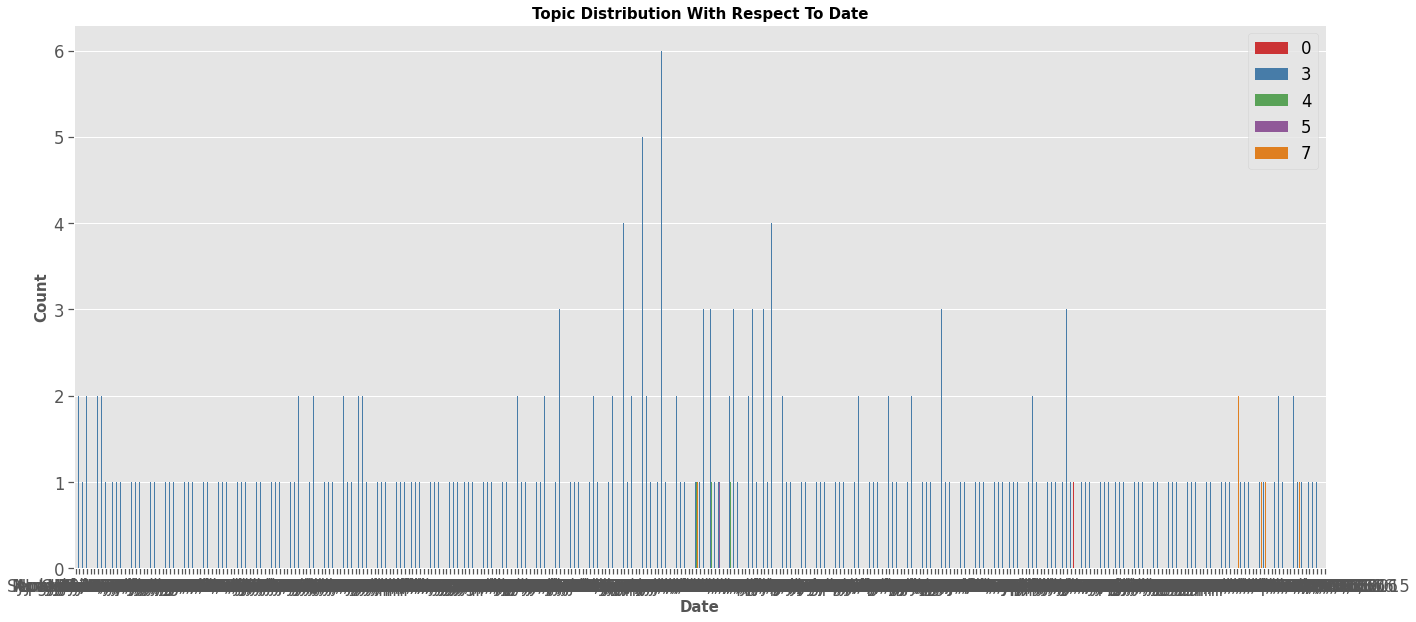

In [196]:
plt.figure(figsize=(20,10))
sns.countplot(campaign['Date'], hue=campaign['lda_topic'], palette = 'Set1',)
plt.legend(loc='upper right')
plt.ylabel('Count', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontsize=15, fontweight='bold')
plt.title('Topic Distribution With Respect To Date', fontsize=15, fontweight='bold')
plt.show()

In [197]:
pd.set_option('display.max_colwidth', 30)

In [198]:
campaign.head()

Candidate Party Type               Date                          Title  \
0  Jeb Bush     1    1      June 15, 2015  Remarks Announcing Candida...   
1  Jeb Bush     1    1      July 30, 2015  Remarks to the National Ur...   
2  Jeb Bush     1    1    August 11, 2015  Remarks at the Ronald Reag...   
3  Jeb Bush     1    1  September 9, 2015  Remarks in Garner, North C...   
4  Jeb Bush     1    1   November 2, 2015      Remarks in Tampa, Florida   

                            Text                     clean_text  \
0  Thank you all very much. I...  Remarks Announcing Candida...   
1  Thank you all very much. I...  Remarks to the National Ur...   
2  Thank you very much. It's ...  Remarks at the Ronald Reag...   
3  Thank you very much. I app...  Remarks in Garner, North C...   
4  Thank you. It's great to b...      Remarks in Tampa, Florida   

                           words                      sentences  char_count  \
0  [thank, you, all, very, mu...  [thank you all very much.,...       12383   
1  [thank, you, all, very, mu...  [thank you all very much.,...       14457   
2  [thank, you, very, much, ....  [thank you very much., it'...       21283   
3  [thank, you, very, much, ....  [thank you very much., i a...       10049   
4  [thank, you, ., it, 's, gr...  [thank you., it's great to...       14189   

   word_count  sentence_count  avg_word_length  avg_sentence_length  \
0        2338              47         5.296407            49.744681   
1        2868             126         5.040795            22.761905   
2        4061             132         5.240827            30.765152   
3        2030              92         4.950246            22.065217   
4        2564              37         5.533931            69.297297   

    datetime                   clean_speech  total_words  \
0 2015-06-15  [thank, you, all, very, mu...         2284   
1 2015-07-30  [thank, you, all, very, mu...         2638   
2 2015-08-11  [thank, you, very, much, i...         3735   
3 2015-09-09  [thank, you, very, much, i...         1880   
4 2015-11-02  [thank, you, it, s, great,...         2550   

   authority/subversion  care/harm  fairness/cheating  liberty/oppression  \
0              0.175131   0.175131           0.131349            0.000000   
1              0.303260   0.075815           0.265353            0.000000   
2              0.321285   0.133869           0.026774            0.000000   
3              0.159574   0.053191           0.053191            0.000000   
4              0.313725   0.117647           0.039216            0.039216   

   loyalty/betrayal  sanctity/degradation  Cluster  \
0          0.306480              0.175131        0   
1          0.151630              0.341168        0   
2          0.107095              0.133869        0   
3          0.053191              0.212766        0   
4          0.000000              0.274510        0   

                            text  Subjectivity  Polarity Analysis  Positive  \
0  Thank you all very much. I...      0.456340  0.171087        1         0   
1  Thank you all very much. I...      0.449360  0.171919        1         0   
2  Thank you very much. It's ...      0.490971  0.082839        1         0   
3  Thank you very much. I app...      0.473084  0.138774        1         0   
4  Thank you. It's great to b...      0.470839  0.177264        1         0   

   Negative  Neutral  total_len  Final_Sentiment  lda_topic  
0         0        0      12383              0.0          3  
1         0        0      14457              0.0          3  
2         0        0      21283              0.0          3  
3         0        0      10049              0.0          3  
4         0        0      14189              0.0          3

In [199]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 7482
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Candidate             430 non-null    object        
 1   Party                 430 non-null    object        
 2   Type                  430 non-null    object        
 3   Date                  430 non-null    object        
 4   Title                 430 non-null    object        
 5   Text                  430 non-null    object        
 6   clean_text            430 non-null    object        
 7   words                 430 non-null    object        
 8   sentences             430 non-null    object        
 9   char_count            430 non-null    int64         
 10  word_count            430 non-null    int64         
 11  sentence_count        430 non-null    int64         
 12  avg_word_length       430 non-null    float64       
 13  avg_sentence_length

# Toxicity Analysis

# Emotion Detection

# Principal Components Analysis